## RDPG-Based Simulation – Synthetic Graphs for Anomaly Detection Pipeline Development

In [1]:
# === Standard Library ===
import random                                             # for seeding and small-scale random ops outside NumPy
import time                                               # to measure runtime of simulation / fitting steps
from itertools import product                             # for Cartesian product in parameter sweeps

# === Numerical Computation & Statistics ===
import numpy as np                                        # core numerical array operations
import pandas as pd                                       # tabular data management
from numpy.linalg import norm, svd                        # dense linear algebra routines
from scipy import sparse as sp                            # sparse matrix structures for memory efficiency
from scipy.linalg import orthogonal_procrustes            # alignment of embeddings (Procrustes)
from scipy.optimize import linear_sum_assignment          # Hungarian algo for label alignment
from scipy.spatial import distance                        # distance metrics
from scipy.special import softmax                         # stable softmax for probability conversion
from scipy.sparse.linalg import svds                      # truncated SVD on sparse matrices
from scipy.stats import ks_1samp, ks_2samp, pearsonr, uniform  # statistical tests and correlations

# === Visualisation ===
import matplotlib.pyplot as plt                          # plotting
import seaborn as sns                                    # high-level plotting style
from matplotlib.colors import ListedColormap             # custom colour maps
from matplotlib.lines import Line2D                      # legend handles
from matplotlib.patches import Patch                     # legend patches
from IPython.display import display                      # inline rich display in notebook

# === Graph & Network Analysis ===
import networkx as nx                                    # graph data structures and algorithms

# === Machine Learning & Embedding ===
from sklearn.cluster import KMeans                       # hard clustering
from sklearn.decomposition import PCA, TruncatedSVD      # dimensionality reduction
from sklearn.manifold import TSNE                        # optional non-linear embedding for visualisation
from sklearn.metrics import (
    pairwise_distances,
    pairwise_distances_argmin_min,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score
)
from sklearn.mixture import GaussianMixture              # soft clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize

# === Probabilistic Programming ===
import pymc as pm                                        # Bayesian model specification & inference
import pytensor.tensor as pt                             # tensor operations for PyMC backend

# === Tabular Formatting ===
from tabulate import tabulate                            # print tables for summaries

In [2]:
# Seed for reproducability
np.random.seed(42)
random.seed(42)

### RDPG Graph Simulation (Unit Ball)

We simulate a **Random Dot Product Graph (RDPG)** with injected anomalies and visualise the distribution of pairwise edge probabilities.

---

#### **Parameters**
- `n_nodes = 10,000`: Number of normal (non-anomalous) nodes  
- `d = 5`: Latent dimension of the embedding space  
- `anomaly_rate = 2%`: Proportion of anomalous nodes (split equally between pure and mixed)  
- Community sizes:  
  - **X1**: 60%  
  - **X2**: 20%  
  - **X3**: 20%

---

#### **Step 1: Latent Structure**
- Generate three distinct clusters (`X1`, `X2`, `X3`) from 2D Gaussian distributions centred at:
  - X1: (0.1, 0.8)
  - X2: (0.5, 0.6)
  - X3: (0.9, 0.2)  
  with a standard deviation of 0.1 in each coordinate.  
- Extend each point to 5D by appending small Gaussian noise ($\sigma = 0.05$) in the extra dimensions.  
- Project all vectors into the **unit ball** by elementwise absolute value and scaling:  
  $$
  \mathbf{x}_i \leftarrow \frac{|\mathbf{x}_i|}{1 + \|\mathbf{x}_i\|_2}
  $$

---

#### **Step 2: Inject Anomalies**
- **Pure anomalies**: Random 5D Gaussian vectors (mean = 0.5, standard deviation = 0.3), projected into the unit ball. These are unrelated to the original clusters.  
- **Mixed anomalies**:  
  - Obtain three cluster centres from a Gaussian Mixture Model (GMM) fit to the base latent positions.  
  - Sample convex combinations of these centres from a Dirichlet(1,1,1) distribution.  
  - Add isotropic Gaussian noise ($\sigma = 0.05$).  
  - Project into the unit ball using the same transformation as above.

---

#### **Step 3: Degree Heterogeneity and Renormalisation**
- Assign each node a scaling factor sampled uniformly from \([0.1, 0.5]\) to simulate heterogeneous node degrees.  
- Scale latent positions:  
  $$
  \mathbf{x}_i \leftarrow s_i \cdot \mathbf{x}_i
  $$  
- Add sparse noise to 1% of coordinates.  
- Renormalise all latent positions into the unit ball.

---

#### **Step 4–6: Graph Generation**
- Compute the edge probability matrix:  
  $$
  P = XX^\top
  $$  
- Sample each upper-triangular entry of \(P\) as a Bernoulli random variable.  
- Reflect to form a symmetric adjacency matrix \(A\) (undirected graph).  
- Convert \(A\) into a NetworkX graph \(G\).

---

#### **Step 7: Node Labelling**
- `0`: Normal node (from X1, X2, or X3)  
- `1`: Structural (pure) anomaly  
- `2`: Mixed-membership anomaly  
- Assign categorical colours for visualisation (e.g., blue, red, orange).

---

#### **Results**
- Graph contains `10,200` nodes (including `200` anomalies).  
- Output includes:
  - Mean edge probability $\bar{P}_{ij}$  
  - Graph density from \(A\)  
  - Histogram of all upper-triangular edge probabilities from \(P\)


Graph created with 10200 nodes:
  - 10000 normal, 100 structural anomalies, 100 mixed anomalies
  - Latent dimension: d = 5
  - Overall anomaly rate: 2.0%
  - Actual graph density: 0.0108
  - Mean edge probability P: 0.0109


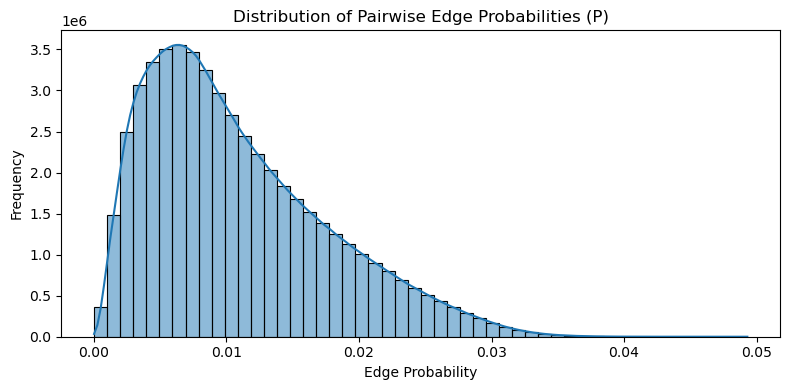

In [3]:
# ------------------------
# RDPG Graph Simulation (unit-ball)
# ------------------------
# Parameters
n_nodes = 10000
d = 5
anomaly_rate = 0.02
n_total_anomalies = int(n_nodes * anomaly_rate)
n_pure_anomalies = n_total_anomalies // 2
n_mixed_anomalies = n_total_anomalies // 2
X1_prop = 0.6
X2_prop = 0.2
X3_prop = 0.2
X1_count = int(n_nodes * X1_prop)
X2_count = int(n_nodes * X2_prop)
X3_count = n_nodes - X1_count - X2_count

# --- Step 1: Latent structure (well inside unit ball)
X1 = np.random.normal(loc=[0.1, 0.8], scale=0.1, size=(X1_count, 2))
X2 = np.random.normal(loc=[0.5, 0.6], scale=0.1, size=(X2_count, 2))
X3 = np.random.normal(loc=[0.9, 0.2], scale=0.1, size=(X3_count, 2))
X_base_2d = np.vstack([X1, X2, X3])

# --- Extend to d=5 with small noise
Z_extra = np.random.normal(scale=0.05, size=(X_base_2d.shape[0], d - 2))
X_base = np.hstack([X_base_2d, Z_extra])
X_base = np.abs(X_base) / (1 + np.linalg.norm(X_base, axis=1, keepdims=True))

# --- Step 2a: Pure anomalies inside unit ball
pure_anomalies = []
for _ in range(n_pure_anomalies):
    anom = np.random.normal(loc=0.5, scale=0.3, size=d)
    anom = np.abs(anom) / (1 + np.linalg.norm(anom))
    pure_anomalies.append(anom)
pure_anomalies = np.vstack(pure_anomalies)

# --- Step 2b: Mixed-membership anomalies
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_base)

def create_mixed_membership_anomalies(gmm_model, n_anomalies=25):
    centres = gmm_model.means_
    mixed_anomalies = []
    for _ in range(n_anomalies):
        weights = np.random.dirichlet([1, 1, 1])
        mix = np.sum(weights[:, None] * centres, axis=0)
        mix += np.random.normal(0, 0.05, size=mix.shape)
        mix = np.abs(mix) / (1 + np.linalg.norm(mix))
        mixed_anomalies.append(mix)
    return np.array(mixed_anomalies)

mixed_anomalies = create_mixed_membership_anomalies(gmm, n_mixed_anomalies)

# --- Combine
X_total = np.vstack([X_base, pure_anomalies, mixed_anomalies])

# --- Step 3: Degree heterogeneity
scaling_factors = np.random.uniform(0.1, 0.5, size=(X_total.shape[0], 1))
X_scaled = X_total * scaling_factors

# --- Step 4: Sparse noise injection to latent positions (before final normalisation)
noise_mask = np.random.rand(X_scaled.shape[0], X_scaled.shape[1]) < 0.01
X_noisy = X_scaled + noise_mask * 0.05
# Normalise after noise injection
X_final = X_noisy / (1 + np.linalg.norm(X_noisy, axis=1, keepdims=True))
P = X_final @ X_final.T

# --- Step 5: Adjacency matrix
A_upper = np.random.binomial(1, np.triu(P, k=1))
A = A_upper + A_upper.T
G = nx.from_numpy_array(A)

# --- Step 6: Labels
true_labels = np.zeros(X_total.shape[0])
true_labels[n_nodes:n_nodes + n_pure_anomalies] = 1
true_labels[n_nodes + n_pure_anomalies:] = 2
anomaly_types = ['normal'] * n_nodes + ['pure'] * n_pure_anomalies + ['mixed'] * n_mixed_anomalies
node_colours = ['blue' if t == 'normal' else 'red' if t == 'pure' else 'orange' for t in anomaly_types]

# --- Results
print(f"\nGraph created with {len(X_total)} nodes:")
print(f"  - {n_nodes} normal, {n_pure_anomalies} structural anomalies, {n_mixed_anomalies} mixed anomalies")
print(f"  - Latent dimension: d = {d}")
print(f"  - Overall anomaly rate: {(n_pure_anomalies + n_mixed_anomalies)/len(X_total)*100:.1f}%")
print(f"  - Actual graph density: {nx.density(G):.4f}")
print(f"  - Mean edge probability P: {P.mean():.4f}")

# --- Plot edge probability distribution
plt.figure(figsize=(8, 4))
sns.histplot(P[np.triu_indices_from(P, k=1)], bins=50, kde=True)
plt.title("Distribution of Pairwise Edge Probabilities (P)")
plt.xlabel("Edge Probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Visualising Latent Communities and Anomalies

We generate a 2D scatterplot of the latent space with clearly marked community structures and injected anomalies.

#### Community & Anomaly Labelling
- Each node is labelled as one of:
  - **Community A**, **B**, **C**
  - **Structural anomaly**
  - **Mixed anomaly**

#### Colour Mapping
- `A → blue`, `B → green`, `C → grey`
- `Structural → red`, `Mixed → orange`

#### Plot Details
- 2D projection of latent vectors (first two dimensions)
- Each point coloured by its community/anomaly label
- Nodes plotted with a slight edge stroke for contrast
- Centroids (from KMeans) labelled as A, B, C for reference
- Custom legend distinguishes community vs. anomaly groups

We visualise the structural separation and anomaly placement within the latent feature space.

---

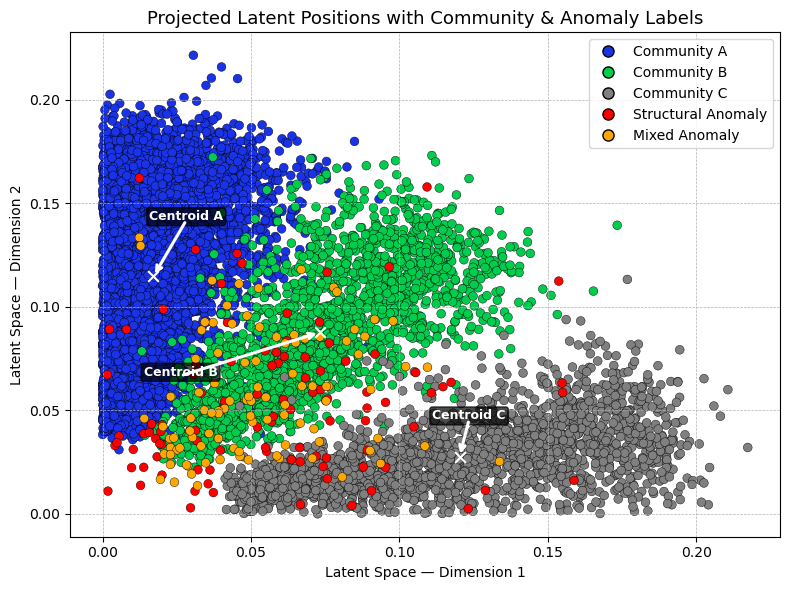

In [4]:
# --- Extended community/anomaly labels ---
community_labels = (
    ['A'] * X1_count +
    ['B'] * X2_count +
    ['C'] * X3_count +
    ['Structural'] * n_pure_anomalies +
    ['Mixed'] * n_mixed_anomalies
)

# --- Explicit RGB Colour Mapping (better PDF rendering) ---
community_colour_map = {
    'A': (0.1, 0.2, 0.9),            # Vivid blue
    'B': (0.0, 0.8, 0.3),            # Strong green
    'C': (0.5, 0.5, 0.5),            # Mid grey
    'Structural': (1.0, 0.0, 0.0),   # Deep red
    'Mixed': (1.0, 0.65, 0.0)        # Bright orange
}
community_colours = [community_colour_map[label] for label in community_labels]

# --- Plot: Community and anomaly view ---
plt.figure(figsize=(8, 6))
plt.scatter(
    X_final[:, 0], X_final[:, 1],
    c=community_colours,
    s=40,
    alpha=1.0,              # Remove transparency for better PDF colour
    edgecolors='k',         
    linewidths=0.3
)
plt.title("Projected Latent Positions with Community & Anomaly Labels", fontsize=13)
plt.xlabel("Latent Space — Dimension 1")
plt.ylabel("Latent Space — Dimension 2")
plt.grid(True, linestyle='--', linewidth=0.5)

# --- Custom legend using same RGB colours ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Community A',
           markerfacecolor=community_colour_map['A'], markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Community B',
           markerfacecolor=community_colour_map['B'], markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Community C',
           markerfacecolor=community_colour_map['C'], markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Structural Anomaly',
           markerfacecolor=community_colour_map['Structural'], markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Mixed Anomaly',
           markerfacecolor=community_colour_map['Mixed'], markeredgecolor='k', markersize=8),
]
plt.legend(handles=legend_elements, loc='best', fontsize=10)

# --- KMeans clustering on final (2D-projected) latent space ---
km = KMeans(n_clusters=3, random_state=42).fit(X_final[:, :2])
centroids_2d = km.cluster_centers_

# --- True post-normalisation community means for matching ---
X1_proj = X_final[:X1_count, :2]
X2_proj = X_final[X1_count:X1_count+X2_count, :2]
X3_proj = X_final[X1_count+X2_count:X1_count+X2_count+X3_count, :2]
true_means = np.array([X1_proj.mean(axis=0), X2_proj.mean(axis=0), X3_proj.mean(axis=0)])

# --- Match centroids to true means ---
dist_matrix = distance.cdist(centroids_2d, true_means)
row_ind, col_ind = linear_sum_assignment(dist_matrix)
label_lookup = {i: chr(65 + j) for i, j in zip(row_ind, col_ind)}

# --- Plot labelled centroids ---
for i, (x, y) in enumerate(centroids_2d):
    label = label_lookup[i]
    plt.text(
        x, y, f'Centroid {label}',
        fontsize=9, fontweight='bold', ha='center', color='white',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.7)
    )

# --- Annotate arrows from each centroid to its matched true cluster mean ---
for i in range(3):
    centroid = centroids_2d[i]
    matched_mean = true_means[col_ind[i]]
    plt.annotate(
        "", xy=matched_mean, xytext=centroid,
        arrowprops=dict(arrowstyle="->", color='white', linewidth=2.2, alpha=1.0)
    )

plt.scatter(true_means[:, 0], true_means[:, 1], c='white', s=60, marker='x', label='True Means')

# --- Save as PDF ---
plt.savefig("latent_plot.pdf", dpi=300, bbox_inches='tight', facecolor='white')

plt.tight_layout()
plt.show()

### Graph Structure & Degree Statistics

Compute global structural metrics and analyse node degree distributions by class.

#### Global Graph Metrics
- **Degree**: Node-wise degree across the graph
- **Clustering coefficient**: Average local transitivity per node
- **Edge density**: Ratio of actual to possible edges
- **Number of edges**: Total edges in the undirected graph

#### Per-Node-Type Degree Stats
We report mean, minimum, maximum, standard deviation, and range for:
- `normal` nodes
- `anomaly` (pure structural anomalies)
- `mixed` (mixed-membership anomalies)

For each group:
- Mean, min, max, std, and range of degrees are reported

#### Visualisation: Degree Distribution
- **Histograms with KDEs** for each node type
- Dashed vertical lines show group means
- Colours: Normal (blue), Structural (red), Mixed (orange)
- A custom legend distinguishes groups and mean markers

We aim to understand how anomalous nodes deviate from the normal population in terms of connectivity patterns, a key signal in graph-based anomaly detection.

---


=== GLOBAL GRAPH STATISTICS ===
Average degree: 110.63
Minimum degree: 16
Maximum degree: 250
Edge density: 0.0108
Average clustering coefficient: 0.0143
Total edges: 564,238

=== DEGREE STATISTICS BY NODE TYPE ===

NORMAL NODES (10000 total):
  Mean degree: 111.1
  Minimum degree: 16
  Maximum degree: 250
  Standard deviation: 42.4
  Range: 16–250

STRUCTURAL NODES (100 total):
  Mean degree: 89.7
  Minimum degree: 25
  Maximum degree: 202
  Standard deviation: 39.4
  Range: 25–202

MIXED NODES (100 total):
  Mean degree: 82.2
  Minimum degree: 22
  Maximum degree: 172
  Standard deviation: 33.2
  Range: 22–172


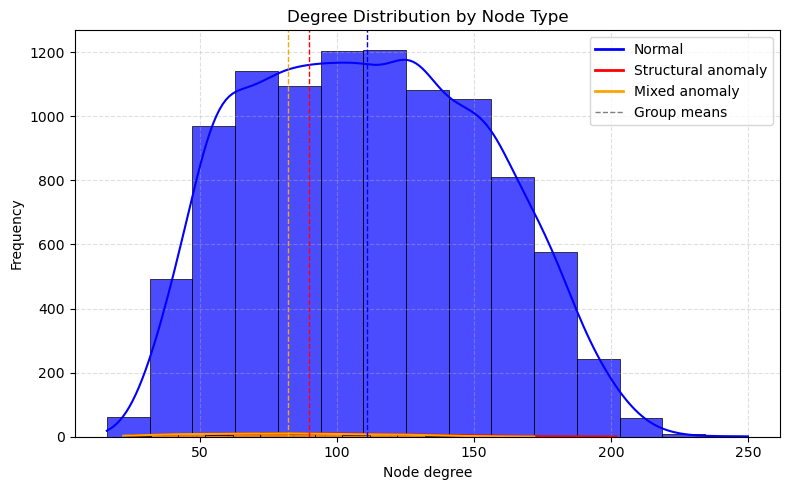

In [5]:
# --- Degree & Structural Statistics ---

# Consistent labels
node_labels = (
    ['normal'] * n_nodes +
    ['structural'] * n_pure_anomalies +
    ['mixed'] * n_mixed_anomalies
)
assert len(G) == len(node_labels), f"Length mismatch: G has {len(G)} nodes, labels = {len(node_labels)}"

# Degrees
degrees = [d for _, d in G.degree()]
degree_series = pd.Series(degrees)

# Global metrics
avg_clustering = nx.average_clustering(G)
density = nx.density(G)
num_edges = G.number_of_edges()

print("\n=== GLOBAL GRAPH STATISTICS ===")
print(f"Average degree: {degree_series.mean():.2f}")
print(f"Minimum degree: {degree_series.min()}")
print(f"Maximum degree: {degree_series.max()}")
print(f"Edge density: {density:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Total edges: {num_edges:,}")

# --- Degree Distribution by Class ---

labels_series = pd.Series(node_labels)
degree_df = pd.DataFrame({'degree': degree_series, 'label': labels_series})

print("\n=== DEGREE STATISTICS BY NODE TYPE ===")
for label in ['normal', 'structural', 'mixed']:
    subset = degree_df.loc[degree_df['label'] == label, 'degree']
    print(f"\n{label.upper()} NODES ({len(subset)} total):")
    print(f"  Mean degree: {subset.mean():.1f}")
    print(f"  Minimum degree: {subset.min()}")
    print(f"  Maximum degree: {subset.max()}")
    print(f"  Standard deviation: {subset.std():.1f}")
    print(f"  Range: {subset.min()}–{subset.max()}")

# --- Plotting ---

plt.figure(figsize=(8, 5))

common_bins = 15  # uniform across groups
plot_specs = [
    ('normal', 'blue', 'Normal'),
    ('structural', 'red', 'Structural anomaly'),
    ('mixed', 'orange', 'Mixed anomaly'),
]

for key, colour, label in plot_specs:
    sns.histplot(
        data=degree_df[degree_df['label'] == key],
        x='degree',
        bins=common_bins,
        color=colour,
        label=label,
        kde=True,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )

# Group mean markers
for key, colour, _ in plot_specs:
    mean_deg = degree_df.loc[degree_df['label'] == key, 'degree'].mean()
    plt.axvline(mean_deg, linestyle='--', color=colour, linewidth=1)

plt.title("Degree Distribution by Node Type")
plt.xlabel("Node degree")
plt.ylabel("Frequency")

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Normal'),
    Line2D([0], [0], color='red', lw=2, label='Structural anomaly'),
    Line2D([0], [0], color='orange', lw=2, label='Mixed anomaly'),
    Line2D([0], [0], linestyle='--', color='grey', lw=1, label='Group means')
]
plt.legend(handles=legend_elements)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### SVD Embedding with Procrustes Alignment (for RDPG Graphs)

We perform dimensionality reduction and visualisation of a graph's adjacency matrix `A` using Singular Value Decomposition (SVD) and Procrustes alignment to recover and interpret latent positions.

---

#### Steps

1. **Ensure Float Precision**  
   Convert the adjacency matrix `A` to floating-point format, as SVD requires numerical precision.

2. **Sparsity Check**  
   Compute the proportion of zero entries in `A` to assess sparsity:
   - If sparsity > 85%, convert `A` to CSR format and use **truncated SVD** (`scipy.sparse.linalg.svds`)
   - Otherwise, use **full SVD** (`scipy.linalg.svd`)

3. **Dimensionality Reduction (SVD)**  
   Extract the top `d = 5` singular vectors and values. The unaligned latent positions are computed as:
   $$
   X_{\text{svd}} = U \cdot \sqrt{\Sigma}
   $$
   where $ U \in \mathbb{R}^{n \times d} $ and $ \Sigma \in \mathbb{R}^{d \times d} $ is a diagonal matrix of the top singular values.

4. **Orthogonal Procrustes Alignment**  
   Align $ X_{\text{svd}} $ to the true latent positions $ X_{\text{final}} $ by solving:
   $$
   \min_{R \in \mathbb{R}^{d \times d}} \| X_{\text{svd}} R - X_{\text{final}} \|_F \quad \text{s.t. } R^\top R = I
   $$
   This corrects for rotational non-identifiability in the RDPG model.

5. **Visualisation**  
   Plot the 2D Procrustes-aligned embedding, coloured by node type:
   - **Blue**: Normal nodes  
   - **Red**: Structural anomalies  
   - **Orange**: Mixed-membership anomalies

---

Sparsity of A: 98.92%
Matrix is sparse (>85%), converting to sparse and using truncated SVD...


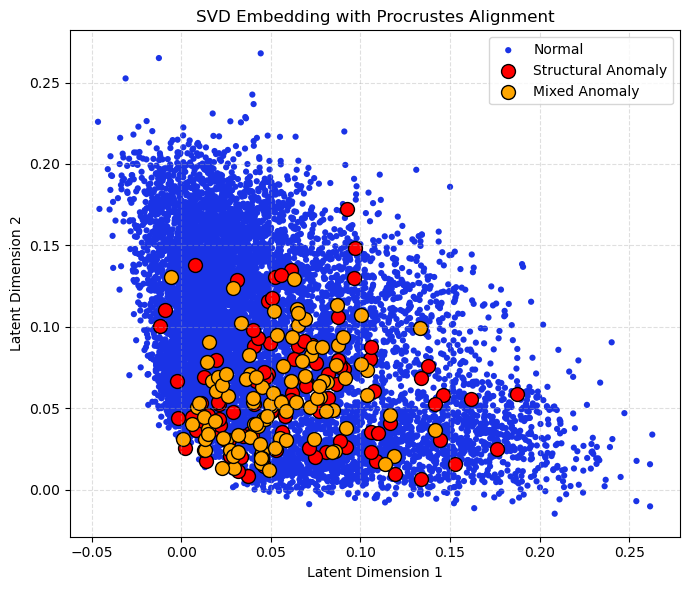

Top 5 singular values: [127.35925902  35.93555866  23.13769555  23.1209759   23.04933177]
Explained variance ratio: [0.84865923 0.06756489 0.02800996 0.02796949 0.02779643]

Explained variance ratio (within top-5 spectrum): [0.849 0.068 0.028 0.028 0.028]

Restricted Procrustes alignment error: 8.6513 (68.78% of baseline norm)


In [6]:
# --- Ensure float precision ---
A = A.astype(float)

# --- Sparsity check ---
sparsity = np.sum(A == 0) / A.size
print(f"Sparsity of A: {sparsity:.2%}")

d = 5  # embedding dimension

# --- SVD decomposition ---
if sparsity > 0.85:
    print("Matrix is sparse (>85%), converting to sparse and using truncated SVD...")
    A_sparse = sp.csr_matrix(A)
    U, S, VT = svds(A_sparse, k=d)
    U, S, VT = U[:, ::-1], S[::-1], VT[::-1, :]
else:
    print("Matrix is dense (<85% sparse), using full SVD...")
    from scipy.linalg import svd
    U, S, VT = svd(A, full_matrices=False)
    U, S, VT = U[:, :d], S[:d], VT[:d, :]

# --- Construct unaligned embedding ---
X_svd = U @ np.diag(np.sqrt(S))

# --- Alignment for plotting (all nodes) ---
R_full, _ = orthogonal_procrustes(X_svd, X_final)
X_svd_aligned_full = X_svd @ R_full

# --- RGB colour definitions (matching previous plot) ---
colour_normal = (0.1, 0.2, 0.9)       # Blue for normal (community)
colour_structural = (1.0, 0.0, 0.0)   # Red for structural anomaly
colour_mixed = (1.0, 0.65, 0.0)       # Orange for mixed anomaly

# --- Visualisation ---
fig, ax = plt.subplots(figsize=(7, 6))

# Normal nodes
ax.scatter(
    X_svd_aligned_full[true_labels == 0, 0],
    X_svd_aligned_full[true_labels == 0, 1],
    label="Normal",
    c=[colour_normal],
    s=20,
    edgecolors='none',
    alpha=1.0
)

# Structural anomalies
ax.scatter(
    X_svd_aligned_full[true_labels == 1, 0],
    X_svd_aligned_full[true_labels == 1, 1],
    label="Structural Anomaly",
    c=[colour_structural],
    s=100,
    edgecolors='black',
    alpha=1.0
)

# Mixed anomalies
ax.scatter(
    X_svd_aligned_full[true_labels == 2, 0],
    X_svd_aligned_full[true_labels == 2, 1],
    label="Mixed Anomaly",
    c=[colour_mixed],
    s=100,
    edgecolors='black',
    alpha=1.0
)

ax.set_title("SVD Embedding with Procrustes Alignment")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.legend(loc='best')
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("svd_embedding.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Spectrum stats ---
print(f"Top {d} singular values: {S}")
print(f"Explained variance ratio: {S**2 / np.sum(S**2)}")
print(f"\nExplained variance ratio (within top-{d} spectrum): {np.round(S**2 / np.sum(S**2), 3)}")

# --- Restricted Procrustes alignment (normal nodes only) ---
normal_mask = (true_labels == 0)
R_normal, _ = orthogonal_procrustes(X_svd[normal_mask], X_final[normal_mask])
X_svd_aligned_normal = X_svd @ R_normal

alignment_error = np.linalg.norm(X_svd_aligned_normal[normal_mask] - X_final[normal_mask], 'fro')
baseline_norm = np.linalg.norm(X_final[normal_mask], 'fro')
print(f"\nRestricted Procrustes alignment error: {alignment_error:.4f} "
      f"({(alignment_error / baseline_norm)*100:.2f}% of baseline norm)")

### t-SNE on SVD Embedding

We apply **t-distributed Stochastic Neighbour Embedding (t-SNE)** to the Procrustes-aligned SVD embedding to explore potential non-linear structure in the latent space.

---

#### Step-by-step Description

1. **Run t-SNE**
   - Input: $X_{\text{svd,aligned}}$ (5D embedding after Procrustes alignment)
   - Parameters:
     - `n_components=2`: Reduce to 2D.
     - `perplexity=50`: Controls balance between local/global structure.
     - `init='pca'`: Initialise using PCA for stability.
     - `learning_rate='auto'`: Automatically adjusts based on dataset size.
     - `random_state=42`: Ensures reproducibility.

2. **Visualise in t-SNE Space**
   - Colour coding:
     - **Blue**: Normal nodes
     - **Red**: Structural anomalies
     - **Orange**: Mixed-membership anomalies
   - Larger markers and black edges emphasise anomalies.

---

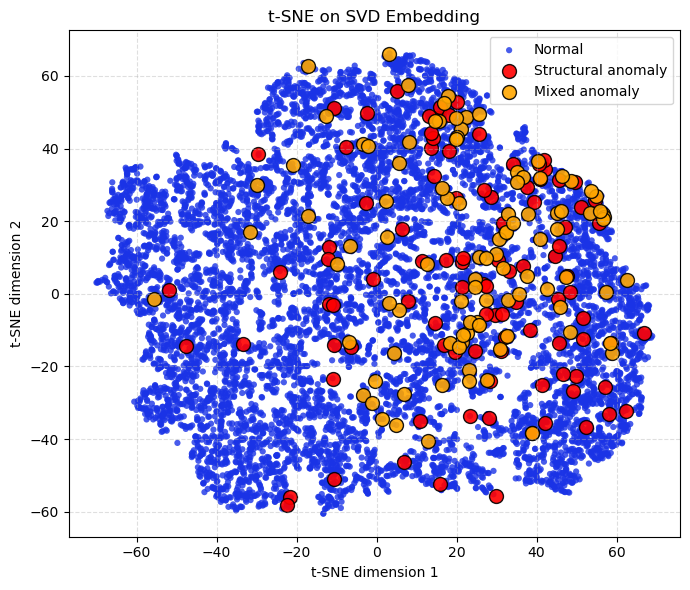

In [7]:
# --- t-SNE on SVD embedding ---
tsne = TSNE(
    n_components=2,
    perplexity=50,
    init='pca',
    learning_rate='auto',
    random_state=42
)
X_tsne = tsne.fit_transform(X_svd_aligned_full)

# --- RGB colours consistent with earlier plots ---
colour_normal = (0.1, 0.2, 0.9)       # Blue
colour_structural = (1.0, 0.0, 0.0)   # Red
colour_mixed = (1.0, 0.65, 0.0)       # Orange

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))

# Normal nodes
ax.scatter(
    X_tsne[true_labels == 0, 0],
    X_tsne[true_labels == 0, 1],
    label="Normal",
    alpha=0.8, c=[colour_normal],
    s=20, edgecolors='none'
)

# Structural anomalies
ax.scatter(
    X_tsne[true_labels == 1, 0],
    X_tsne[true_labels == 1, 1],
    label="Structural anomaly",
    c=[colour_structural],
    edgecolor='black', s=100, alpha=0.9
)

# Mixed anomalies
ax.scatter(
    X_tsne[true_labels == 2, 0],
    X_tsne[true_labels == 2, 1],
    label="Mixed anomaly",
    c=[colour_mixed],
    edgecolor='black', s=100, alpha=0.9
)

ax.set_title("t-SNE on SVD Embedding")
ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")
ax.legend(loc='best')
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("tsne_on_svd_embedding.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Optimal Cluster Number Selection (on SVD Embedding)

We assess the optimal number of clusters $ k \in [2, 9] $ using three common unsupervised metrics:

---

#### Metrics Evaluated

1. **K-Means Inertia (Elbow Method)**  
   - Measures total within-cluster variance.
   - Lower values are better, but the *elbow* point indicates where further gains diminish.

2. **Silhouette Score**  
   - Quantifies the separation between clusters.
   - Ranges from −1 to 1; higher values indicate more distinct clusters.
   - Best value observed at:
     ```
     k = best_k_sil
     ```

3. **Gaussian Mixture Model (GMM): AIC and BIC**
   - **AIC (Akaike Information Criterion)** and **BIC (Bayesian Information Criterion)** balance model fit with complexity penalties.
   - Lower values indicate better model fit with complexity control.
   - Minimums observed at:
     ```
     AIC → k = min_aic_k
     BIC → k = min_bic_k
     ```

---

#### Visual Summary

- **Left**: K-Means inertia vs. $ k $ (Elbow Method)  
- **Middle**: Silhouette score with best $ k $ marked in red  
- **Right**: GMM AIC/BIC vs. $ k $ with minima indicated  

---

#### Observations

- Silhouette suggests  $k =$ {best_k_sil}
- AIC and BIC both suggest $k =$ {min_bic_k}

---

#### Example Output Stats

```text
Top silhouette score: best_k_sil = {best_k_sil}
BIC minimum: min_bic_k = {min_bic_k}, BIC = {min_bic:.2f}
AIC minimum: min_aic_k = {min_aic_k}, AIC = {min_aic:.2f}
SVD-aligned mean: {X_svd_aligned_full.mean(axis=0).round(4)}
SVD-aligned std: {X_svd_aligned_full.std(axis=0).round(4)}

k=2: Silhouette Score = 0.219
k=3: Silhouette Score = 0.199
k=4: Silhouette Score = 0.190
k=5: Silhouette Score = 0.207
k=6: Silhouette Score = 0.141
k=7: Silhouette Score = 0.156
k=8: Silhouette Score = 0.163
k=9: Silhouette Score = 0.169


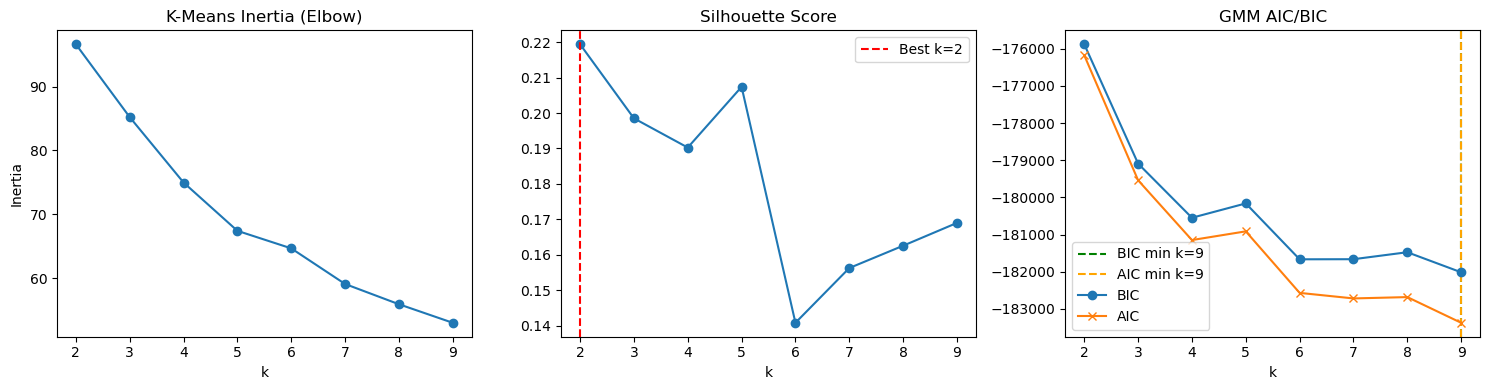

Suggested optimal k based on silhouette score: 2

Suggested optimal k based on minimum BIC: 9 (BIC=-182014.85)
Suggested optimal k based on minimum AIC: 9 (AIC=-183374.12)

X_svd_aligned mean: [0.0489 0.0911 0.0065 0.0064 0.0067]
X_svd_aligned std: [0.0516 0.0503 0.0476 0.0475 0.0475]

Sample AIC: [-176174.1299727013, -179537.8512748772, -181147.56474661274, -180912.99462433028, -182569.25856903958, -182718.30985454083, -182682.35408923443, -183374.12183204878]


In [8]:
# --- Determine the optimal k using SVD embedding ---

Ks = list(range(2, 10))
inertias = []
sil_scores = []
bics = []
aics = []
best_sil_score = -1
best_k_sil = None

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X_svd_aligned_full)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_svd_aligned_full, km.labels_)
    sil_scores.append(sil)
    if sil > best_sil_score:
        best_sil_score = sil
        best_k_sil = k
    print(f"k={k}: Silhouette Score = {sil:.3f}")
    
    gm = GaussianMixture(n_components=k, random_state=42).fit(X_svd_aligned_full)
    bics.append(gm.bic(X_svd_aligned_full))
    aics.append(gm.aic(X_svd_aligned_full))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(Ks, inertias, marker='o')
plt.title("K-Means Inertia (Elbow)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1, 3, 2)
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.axvline(x=best_k_sil, linestyle='--', color='red', label=f'Best k={best_k_sil}')
plt.legend()

plt.subplot(1, 3, 3)

# Minimum AIC and BIC values with corresponding k
min_bic = min(bics)
min_bic_k = Ks[bics.index(min_bic)]

min_aic = min(aics)
min_aic_k = Ks[aics.index(min_aic)]

plt.axvline(x=min_bic_k, linestyle='--', color='green', label=f'BIC min k={min_bic_k}')
plt.axvline(x=min_aic_k, linestyle='--', color='orange', label=f'AIC min k={min_aic_k}')

plt.plot(Ks, bics, label="BIC", marker='o')
plt.plot(Ks, aics, label="AIC", marker='x')
plt.title("GMM AIC/BIC")
plt.xlabel("k")
plt.legend()


plt.tight_layout()
plt.savefig("k_selection_simulated.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Suggested optimal k based on silhouette score: {best_k_sil}")
print(f"\nSuggested optimal k based on minimum BIC: {min_bic_k} (BIC={min_bic:.2f})")
print(f"Suggested optimal k based on minimum AIC: {min_aic_k} (AIC={min_aic:.2f})")
print("\nX_svd_aligned mean:", X_svd_aligned_full.mean(axis=0).round(4))
print("X_svd_aligned std:", X_svd_aligned_full.std(axis=0).round(4))
print("\nSample AIC:", aics)

### GMM and K-Means Clustering (k = 5)

We apply **K-Means** and **Gaussian Mixture Models (GMM)** with \( k = 5 \), matching the known community structure in the synthetic graph.

---

#### Steps:

1. **Fit clusterers** on both:
   - True latent positions `X_scaled`
   - SVD-aligned embedding `X_svd_aligned_full`

2. **Evaluate** using the **silhouette score** to assess separation quality.

3. **Visualise** with anomalies overlaid:
   - Red: Structural anomalies
   - Orange: Mixed-membership anomalies

4. **Save output** to `Fig2_GMM_Clustering.pdf`

---


=== Silhouette Scores ===
Latent | k=5: KMeans = 0.448, GMM = 0.320
SVD | k=5: KMeans = 0.207, GMM = 0.140


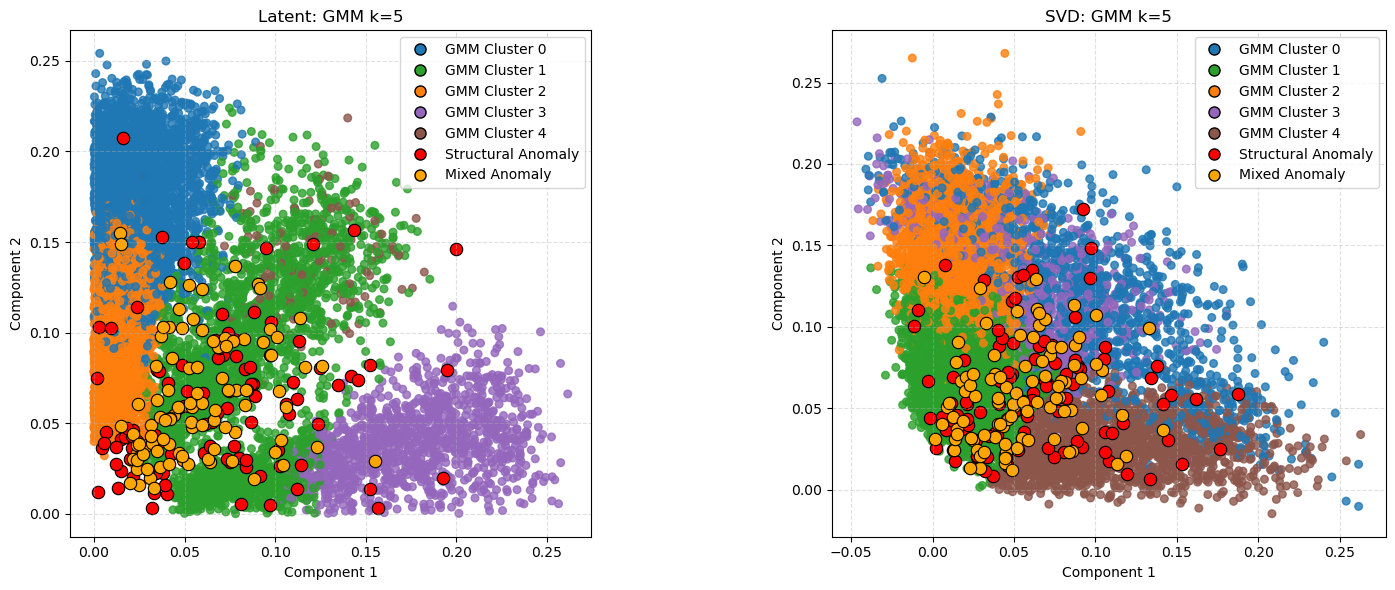

GMM cluster labels used (latent): [0 1 2 3 4]
GMM cluster labels used (svd): [0 1 2 3 4]


In [9]:
# --- Clustering Helper Function ---
def fit_clusterers(X, k_values, random_state=42):
    """
    Fit KMeans and GMM for a list of k values.
    Returns a dictionary of results per k.
    """
    results = {}
    for k in (k_values if isinstance(k_values, list) else [k_values]):
        km = KMeans(n_clusters=k, random_state=random_state)
        labels_km = km.fit_predict(X)

        gm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state)
        labels_gm = gm.fit_predict(X)

        results[k] = {
            'kmeans_labels': labels_km,
            'kmeans_centers': km.cluster_centers_,
            'gmm_labels': labels_gm,
            'gmm_model': gm
        }
    return results

# --- Parameters ---
k = 5  # number of clusters (can be a list)
k_list = [k]
normal_idx = (true_labels == 0)
anomaly_idx = (true_labels == 1)
mixed_idx = (true_labels == 2)

# --- Fit Clusterers ---
latent_results = fit_clusterers(X_scaled, k_list)
svd_results    = fit_clusterers(X_svd_aligned_full, k_list)

# --- Check centres/models if needed ---
centres_true_opt = latent_results[k]['kmeans_centers']
centres_svd_opt  = svd_results[k]['kmeans_centers']
gmm_true_opt     = latent_results[k]['gmm_model']
gmm_svd_opt      = svd_results[k]['gmm_model']

# --- Evaluate Clustering via Silhouette Scores ---
print("=== Silhouette Scores ===")
for name, X, result in [('Latent', X_scaled, latent_results), ('SVD', X_svd_aligned_full, svd_results)]:
    for k_val in k_list:
        sil_km = silhouette_score(X, result[k_val]['kmeans_labels'])
        sil_gm = silhouette_score(X, result[k_val]['gmm_labels'])
        print(f"{name} | k={k_val}: KMeans = {sil_km:.3f}, GMM = {sil_gm:.3f}")

# --- Fixed 5-colour palette (colour-blind friendly) mapped by cluster index 0..k-1 ---
cluster_colours = [
    '#1f77b4',  # muted blue
    '#2ca02c',  # green
    '#ff7f0e',  # orange
    '#9467bd',  # purple
    '#8c564b',  # brown
]
# If k > len(cluster_colours), palette will cycle (not needed here, but safe)
label_to_colour = {i: cluster_colours[i % len(cluster_colours)] for i in range(k)}

# --- Plot Clustering Results ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (name, X, idx_anom, idx_mix, result) in enumerate([
    ("Latent", X_scaled, anomaly_idx, mixed_idx, latent_results),
    ("SVD",    X_svd_aligned_full, anomaly_idx, mixed_idx, svd_results)
]):
    ax = axes[i]

    # GMM labels
    gmm_labels = result[k]['gmm_labels']
    colours = [label_to_colour[int(lbl)] for lbl in gmm_labels]

    # Scatter of all nodes by their cluster colour
    ax.scatter(X[:, 0], X[:, 1], c=colours, s=30, alpha=0.8)

    # Overlay anomalies (slightly larger for visibility)
    ax.scatter(X[idx_anom, 0], X[idx_anom, 1],
               facecolors='red', edgecolors='black',
               s=80, linewidths=0.8, label='Structural Anomaly')
    ax.scatter(X[idx_mix, 0], X[idx_mix, 1],
               facecolors='orange', edgecolors='black',
               s=80, linewidths=0.8, label='Mixed Anomaly')

    ax.set_title(f"{name}: GMM k={k}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_aspect('equal', adjustable='box')

    # Legend: only show cluster entries actually present in this panel
    used_labels = np.unique(gmm_labels)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'GMM Cluster {int(label)}',
               markerfacecolor=label_to_colour[int(label)], markeredgecolor='k', markersize=8)
        for label in used_labels
    ]
    legend_elements += [
        Line2D([0], [0], marker='o', color='w', label='Structural Anomaly',
               markerfacecolor='red', markeredgecolor='black', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Mixed Anomaly',
               markerfacecolor='orange', markeredgecolor='black', markersize=8),
    ]
    ax.legend(handles=legend_elements, loc='best', frameon=True)

plt.tight_layout()
fig.savefig("Fig2_GMM_Clustering.pdf", format='pdf', bbox_inches='tight')
plt.show()

print("GMM cluster labels used (latent):", np.unique(latent_results[k]['gmm_labels']))
print("GMM cluster labels used (svd):",    np.unique(svd_results[k]['gmm_labels']))

### Entropy-Based Anomaly Scoring via MMSBM Approximation

This section computes **soft clustering-based anomaly scores** by approximating the **Mixed-Membership Stochastic Block Model (MMSBM)** using a Gaussian Mixture Model (GMM), applied to both the **true latent positions** and the **SVD-inferred embedding**.

---

#### Key Steps

1. **GMM Soft Assignment (MMSBM Approximation)**
   - Fit a GMM with `n_communities=3` to `X_scaled` (latent) and `X_svd_aligned_full` (SVD).
   - Extract:
     - **Membership probabilities** per node
     - **Entropy** as a soft anomaly score:  
       $$
       H_i = -\sum_k p_{ik} \log p_{ik}
       $$
     - **Negative Log-Likelihood (NLL)** per node:  
       $$
       \text{LL}_i = -\log P(x_i \mid \text{GMM})
       $$

2. **Distance-to-Centroid Score (KMeans)**
   - Compute Euclidean distance from each point to its closest KMeans centre (based on earlier optimal $ k = 5 $).

3. **Anomaly Metrics Evaluation**
   - For each score (entropy, NLL, KMeans distance), compute:
     - **AUC**
     - **Precision@k** and **Recall@k** for $ k \in \{10, 25, 50\} $
     - Per anomaly type: Structural (label 1) and Mixed-Membership (label 2)

4. **KDE Visualisation**
   - Kernel Density Estimates show the **distribution of scores** by class (Normal, Structural, Mixed).
   - Includes mean, median, min, and max values for interpretability.

5. **KS Tests**
   - Two-sample Kolmogorov–Smirnov tests compare the entropy distributions:
     - Normal vs Structural
     - Normal vs Mixed

---

#### Interpretation

- **Entropy** captures role uncertainty and is effective for detecting **mixed-membership anomalies**.
- **GMM NLL** highlights outliers poorly explained by any mixture component (structural or mixed).
- **KMeans Distance** performs competitively for structural deviations.
- **SVD vs Latent** comparisons reveal robustness and limitations of inferred embeddings.

---

In [10]:
def run_mmsbm_scoring(X, true_labels, n_communities=8, random_state=42):
    """
    Run GMM on latent space X to approximate MMSBM:
    - Returns entropy, LL scores, and anomaly metrics.
    """
    gmm = GaussianMixture(n_components=n_communities, covariance_type='full', random_state=random_state)
    gmm.fit(X)

    probs = gmm.predict_proba(X)
    entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
    ll_score = -gmm.score_samples(X)  # Higher is more anomalous

    metrics_struct = evaluate_entropy_scores(entropy, true_labels, anomaly_type_label=1)
    metrics_mixed = evaluate_entropy_scores(entropy, true_labels, anomaly_type_label=2)

    return {
        'gmm_model': gmm,
        'membership_probs': probs,
        'entropy': entropy,
        'll_score': ll_score,
        'metrics': {
            'Structural': metrics_struct,
            'Mixed': metrics_mixed
        }
    }

def evaluate_scores(score_vector, true_labels, anomaly_type_label, top_k_list=[10, 25, 50]):
    """
    Evaluate AUC and top-k precision/recall for a given anomaly score vector.
    Higher score = more anomalous.
    """
    results = {}
    is_anomaly = (true_labels == anomaly_type_label).astype(int)
    auc = roc_auc_score(is_anomaly, score_vector)
    results['AUC'] = auc
    for k in top_k_list:
        topk_idx = np.argsort(score_vector)[-k:]
        pred = np.zeros_like(is_anomaly)
        pred[topk_idx] = 1
        results[f'Precision@{k}'] = precision_score(is_anomaly, pred, zero_division=0)
        results[f'Recall@{k}'] = recall_score(is_anomaly, pred, zero_division=0)
    return results

def evaluate_entropy_scores(entropy_scores, true_labels, anomaly_type_label, top_k_list=[10, 25, 50]):
    """
    Evaluate AUC and top-k precision/recall for a given entropy score vector.
    Higher entropy = more anomalous.
    """
    results = {}
    is_anomaly = (true_labels == anomaly_type_label).astype(int)
    auc = roc_auc_score(is_anomaly, entropy_scores)
    results['AUC'] = auc
    for k in top_k_list:
        topk_idx = np.argsort(entropy_scores)[-k:]
        pred = np.zeros_like(is_anomaly)
        pred[topk_idx] = 1
        results[f'Precision@{k}'] = precision_score(is_anomaly, pred, zero_division=0)
        results[f'Recall@{k}'] = recall_score(is_anomaly, pred, zero_division=0)
    return results

def print_anomaly_metrics_table(metrics_dict, space_label, method_label=""):
    """
    Print a formatted table of anomaly detection metrics (AUC, Precision@k, Recall@k) 
    for each anomaly type.
    """
    title = f"{space_label}"
    if method_label:
        title += f" — {method_label}"
    print(f"\n--- {title} ---")

    headers = ["Anomaly Type", "AUC", "Precision@10", "Recall@10", "Precision@25", "Recall@25", "Precision@50", "Recall@50"]
    table = []
    for anomaly_type, metrics in metrics_dict.items():
        row = [anomaly_type] + [f"{metrics[key]:.3f}" for key in ['AUC', 'Precision@10', 'Recall@10',
                                                                  'Precision@25', 'Recall@25', 'Precision@50', 'Recall@50']]
        table.append(row)
    print(tabulate(table, headers=headers, tablefmt="github"))

# Consistent colour palette
PALETTE = {
    0: (0.1, 0.2, 0.9),   # Normal  → vivid blue
    1: (1.0, 0.0, 0.0),   # Structural → deep red
    2: (1.0, 0.65, 0.0),  # Mixed → bright orange
}
LABELS = {0: "Normal", 1: "Structural", 2: "Mixed"}

def plot_score_kdes(df, score_cols, titles, palette=PALETTE, labels=LABELS):
    """
    Plot side-by-side KDEs for score columns with fixed, consistent colours.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must include 'true_label' and the given score columns.
    score_cols : list[str]
        Columns to plot, e.g. ['entropy_latent', 'entropy_svd'].
    titles : list[str]
        Plot titles for each subplot (same length as score_cols).
    palette : dict[int, tuple], optional
        Mapping {class_id: colour}, defaults to PALETTE.
    labels : dict[int, str], optional
        Mapping {class_id: display_name}, defaults to LABELS.
    """
    fig, axes = plt.subplots(1, len(score_cols), figsize=(7*len(score_cols), 5), sharey=False)

    # Ensure axes is iterable even for a single column
    if len(score_cols) == 1:
        axes = [axes]

    for ax, col, title in zip(axes, score_cols, titles):
        stats_lines = []
        for cls in [0, 1, 2]:
            name = labels[cls]
            colour = palette[cls]
            vals = df.loc[df['true_label'] == cls, col]
            if len(vals) == 0:
                continue

            sns.kdeplot(vals, label=name, fill=True, alpha=0.6, ax=ax, color=colour)

            # Stats for the annotation box
            mean = vals.mean()
            median = np.median(vals)
            vmin = vals.min()
            vmax = vals.max()
            stats_lines.append(f"{name}: μ={mean:.2f}, M={median:.2f}, min={vmin:.2f}, max={vmax:.2f}")

        ax.set_title(title)
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.grid(True)
        ax.legend(title="Classes", loc="upper right")

        ax.text(0.98, 0.4, "\n".join(stats_lines),
                transform=ax.transAxes, fontsize=9,
                va='bottom', ha='right',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.85))

        # Entropy is naturally non-negative; keep x-axis tidy
        if "entropy" in col.lower():
            ax.set_xlim(left=0)

    plt.tight_layout()
    plt.show()

def print_score_stats_table(df, score_cols):
    """
    Prints a stats table (mean, median, min, max) for each score column and anomaly type.
    """
    for col in score_cols:
        print(f"\n--- Stats for {col} ---")
        headers = ["Class", "Mean", "Median", "Min", "Max"]
        table = []
        for lbl, name in zip([0, 1, 2], ['Normal', 'Structural', 'Mixed']):
            vals = df.loc[df['true_label'] == lbl, col]
            table.append([
                name,
                f"{vals.mean():.3f}",
                f"{np.median(vals):.3f}",
                f"{vals.min():.3f}",
                f"{vals.max():.3f}"
            ])
        print(tabulate(table, headers=headers, tablefmt="github"))

def run_ks_tests(entropy, true_labels, label_space=""):
    print(f"\n--- Kolmogorov–Smirnov Tests ({label_space}) ---")
    n, s, m = entropy[true_labels == 0], entropy[true_labels == 1], entropy[true_labels == 2]
    ks_struct = ks_2samp(n, s)
    ks_mixed = ks_2samp(n, m)
    print(f"Normal vs Structural: D = {ks_struct.statistic:.3f}, p = {ks_struct.pvalue:.2e}")
    print(f"Normal vs Mixed:      D = {ks_mixed.statistic:.3f}, p = {ks_mixed.pvalue:.2e}")

In [11]:
# === MMSBM scoring on latent and SVD ===
# We fix k=3 for entropy-based scoring to measure ambiguity among macro-roles; 
# larger k reduces discriminability as GMMs over-partition normals.
mmsbm_latent = run_mmsbm_scoring(X_scaled, true_labels, n_communities=3)
mmsbm_svd = run_mmsbm_scoring(X_svd_aligned_full, true_labels, n_communities=3)

# === KMeans and GMM scores ===
kmeans_dist_latent = pairwise_distances(X_scaled, centres_true_opt).min(axis=1)
kmeans_dist_svd = pairwise_distances(X_svd_aligned_full, centres_svd_opt).min(axis=1)

# === Combined Score DataFrame ===
anomaly_score_df = pd.DataFrame({
    'true_label': true_labels,
    'kmeans_dist_latent': kmeans_dist_latent,
    'kmeans_dist_svd': kmeans_dist_svd,
    'gmm_score_latent': mmsbm_latent['ll_score'],
    'gmm_score_svd': mmsbm_svd['ll_score'],
    'entropy_latent': mmsbm_latent['entropy'],
    'entropy_svd': mmsbm_svd['entropy']
})

# === KMeans and GMM AUC (Latent) etc ===
kmeans_latent_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['kmeans_dist_latent'], true_labels, anomaly_type_label=1),
    "Mixed": evaluate_scores(anomaly_score_df['kmeans_dist_latent'], true_labels, anomaly_type_label=2)
}

gmm_latent_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['gmm_score_latent'], true_labels, anomaly_type_label=1),
    "Mixed": evaluate_scores(anomaly_score_df['gmm_score_latent'], true_labels, anomaly_type_label=2)
}

# === KMeans and GMM AUC (SVD) ===
kmeans_svd_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['kmeans_dist_svd'], true_labels, anomaly_type_label=1),
    "Mixed": evaluate_scores(anomaly_score_df['kmeans_dist_svd'], true_labels, anomaly_type_label=2)
}

gmm_svd_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['gmm_score_svd'], true_labels, anomaly_type_label=1),
    "Mixed": evaluate_scores(anomaly_score_df['gmm_score_svd'], true_labels, anomaly_type_label=2)
}


--- Stats for entropy_latent ---
| Class      |   Mean |   Median |   Min |   Max |
|------------|--------|----------|-------|-------|
| Normal     |  0.164 |    0.039 |    -0 | 1.088 |
| Structural |  0.012 |   -0     |    -0 | 0.673 |
| Mixed      |  0.189 |    0.065 |     0 | 0.832 |

--- Stats for entropy_svd ---
| Class      |   Mean |   Median |   Min |   Max |
|------------|--------|----------|-------|-------|
| Normal     |  0.272 |    0.19  |    -0 | 1.097 |
| Structural |  0.391 |    0.49  |    -0 | 1.032 |
| Mixed      |  0.42  |    0.444 |     0 | 1.069 |

--- Stats for gmm_score_latent ---
| Class      |    Mean |   Median |     Min |    Max |
|------------|---------|----------|---------|--------|
| Normal     | -14.787 |  -15.162 | -18.141 | -1.264 |
| Structural |  -1.368 |   -3.053 |  -8.416 | 17.188 |
| Mixed      | -13.181 |  -14.315 | -17.938 | -1.638 |

--- Stats for gmm_score_svd ---
| Class      |   Mean |   Median |     Min |    Max |
|------------|--------|----

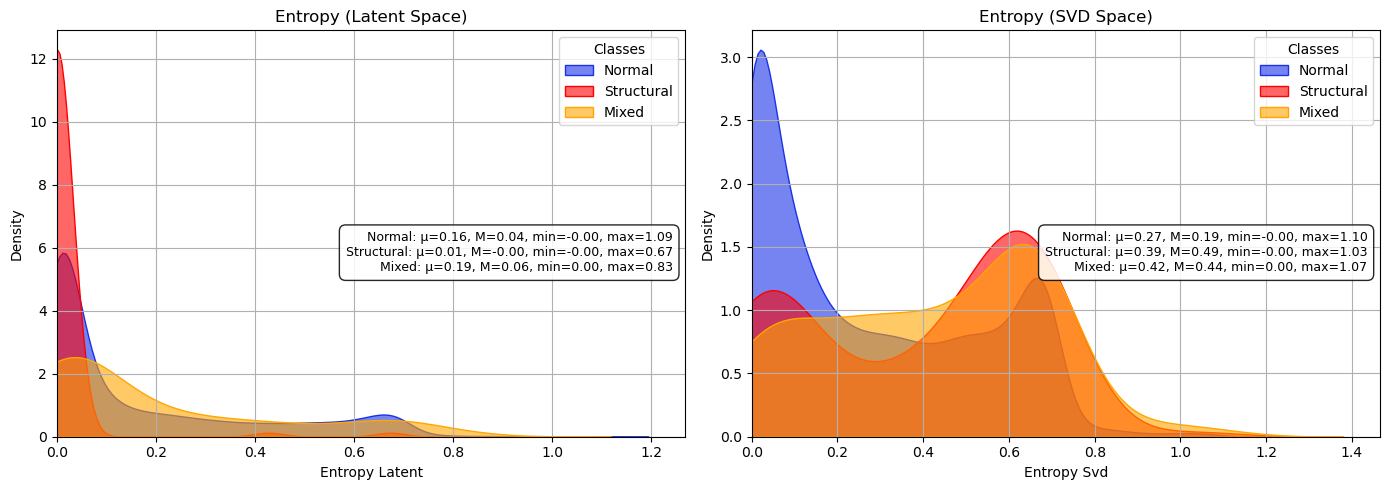

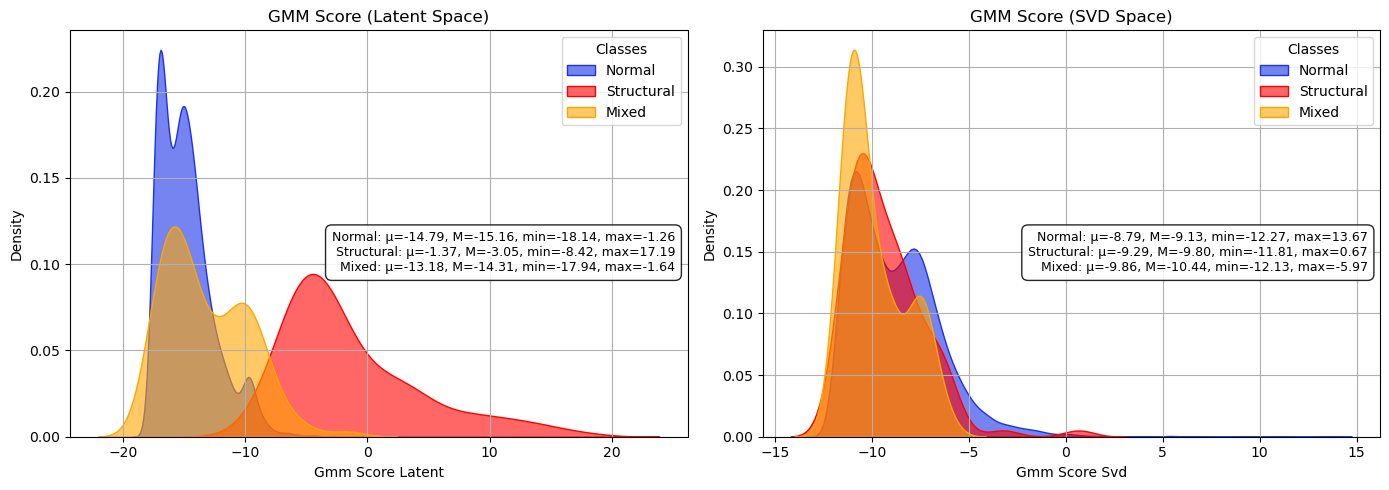

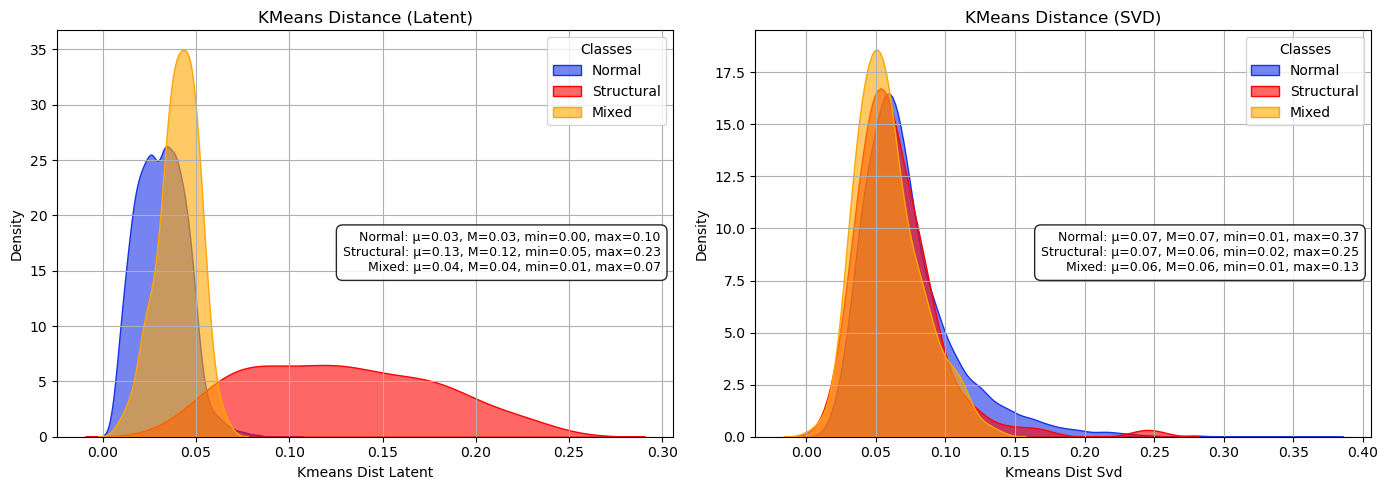


--- Latent Space ---
| Anomaly Type   |   AUC |   Precision@10 |   Recall@10 |   Precision@25 |   Recall@25 |   Precision@50 |   Recall@50 |
|----------------|-------|----------------|-------------|----------------|-------------|----------------|-------------|
| Structural     | 0.031 |              0 |           0 |              0 |           0 |           0    |        0    |
| Mixed          | 0.557 |              0 |           0 |              0 |           0 |           0.02 |        0.01 |

--- SVD Space ---
| Anomaly Type   |   AUC |   Precision@10 |   Recall@10 |   Precision@25 |   Recall@25 |   Precision@50 |   Recall@50 |
|----------------|-------|----------------|-------------|----------------|-------------|----------------|-------------|
| Structural     | 0.618 |            0   |        0    |           0.04 |        0.01 |           0.02 |        0.01 |
| Mixed          | 0.661 |            0.1 |        0.01 |           0.04 |        0.01 |           0.04 |        0.02 |

In [12]:
# === Print Score Stats ===
print_score_stats_table(anomaly_score_df, [
    'entropy_latent', 'entropy_svd',
    'gmm_score_latent', 'gmm_score_svd',
    'kmeans_dist_latent', 'kmeans_dist_svd'
])

print()

###### === KDE Plots ===
plot_score_kdes(
    anomaly_score_df,
    score_cols=['entropy_latent', 'entropy_svd'],
    titles=["Entropy (Latent Space)", "Entropy (SVD Space)"]
)

plot_score_kdes(
    anomaly_score_df,
    score_cols=['gmm_score_latent', 'gmm_score_svd'],
    titles=["GMM Score (Latent Space)", "GMM Score (SVD Space)"]
)

plot_score_kdes(
    anomaly_score_df,
    score_cols=['kmeans_dist_latent', 'kmeans_dist_svd'],
    titles=["KMeans Distance (Latent)", "KMeans Distance (SVD)"]
)

# === Metrics Tables ===
print_anomaly_metrics_table(mmsbm_latent['metrics'], "Latent Space")
print_anomaly_metrics_table(mmsbm_svd['metrics'], "SVD Space")

# === KS Tests ===
run_ks_tests(mmsbm_latent['entropy'], true_labels, "Latent Space")
run_ks_tests(mmsbm_svd['entropy'], true_labels, "SVD Space")

# === KMeans and GMM Metrics (Latent) ===
print_anomaly_metrics_table(kmeans_latent_metrics, "KMeans Distance (Latent)")
print_anomaly_metrics_table(gmm_latent_metrics, "GMM Log-Likelihood (Latent)")

print()

# === KMeans and GMM Metrics (SVD) ===
print_anomaly_metrics_table(kmeans_svd_metrics, "KMeans Distance (SVD)")
print_anomaly_metrics_table(gmm_svd_metrics, "GMM Log-Likelihood (SVD)")

### Empirical p-value Analysis for Anomaly Scores

This snippet evaluates the **calibration** of anomaly scores by converting them to **empirical CDF p-values** and testing their uniformity.

**Workflow:**
1. **Convert scores to empirical p-values**  
   - Sort scores and compute percentile ranks (`pvals`), optionally inverting if higher scores indicate more anomalous behaviour (`inverse=True`).
2. **Overall calibration check**  
   - Plot histogram of `pvals` to visualise deviation from uniformity.
   - Perform **one-sample KS test** vs. `U[0,1]` to quantify miscalibration.
3. **Anomaly-specific calibration** *(if labels provided)*  
   - Split `pvals` into *Structural* and *Mixed* anomalies.
   - Plot their histograms and run KS tests against `U[0,1]` separately.
   - Report mean p-values for each anomaly type to identify bias in detection.

**Purpose:**  
A well-calibrated anomaly score should yield uniform p-values under the null (normal class).  
Concentration of low p-values in anomalies indicates effective separation from the normal population.

---

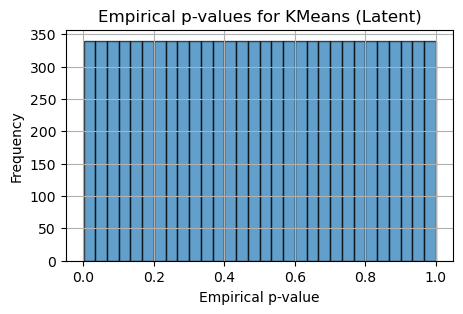

KS test vs. U[0,1] for KMeans (Latent) → D = 0.000, p = 1.000e+00


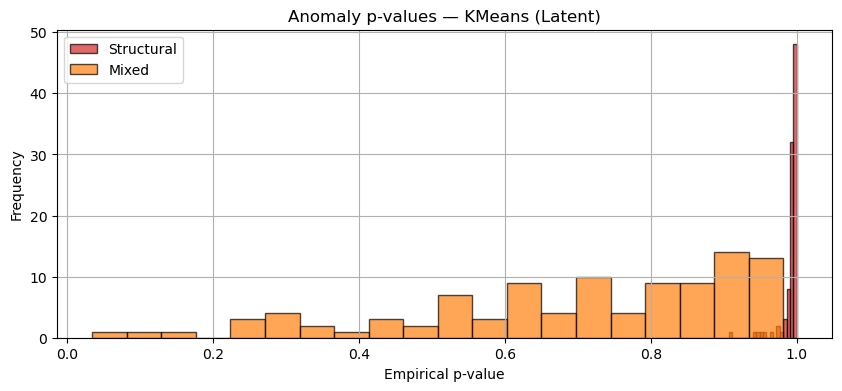

KS (Structural) → D = 0.933, p = 1.184e-117
KS (Mixed) → D = 0.333, p = 2.175e-10
Mean p-value (Structural): 0.991
Mean p-value (Mixed): 0.700


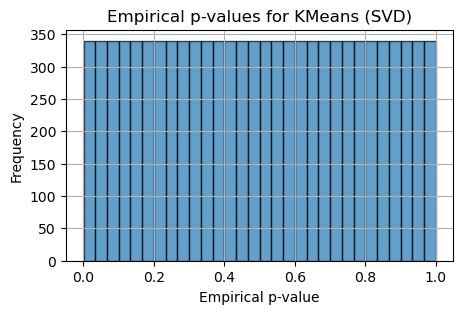

KS test vs. U[0,1] for KMeans (SVD) → D = 0.000, p = 1.000e+00


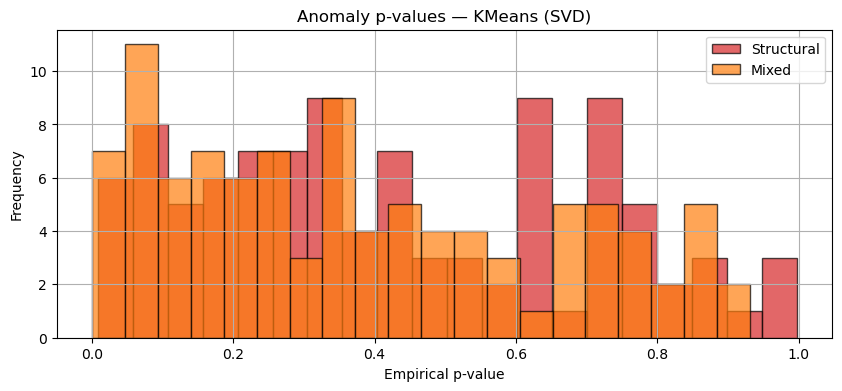

KS (Structural) → D = 0.147, p = 2.343e-02
KS (Mixed) → D = 0.197, p = 7.222e-04
Mean p-value (Structural): 0.429
Mean p-value (Mixed): 0.381


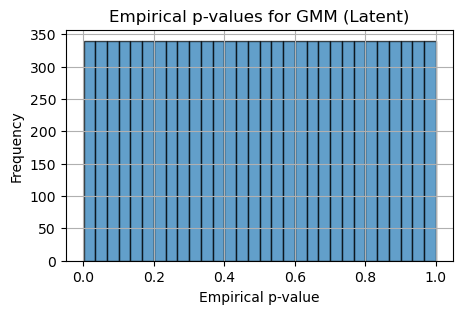

KS test vs. U[0,1] for GMM (Latent) → D = 0.000, p = 1.000e+00


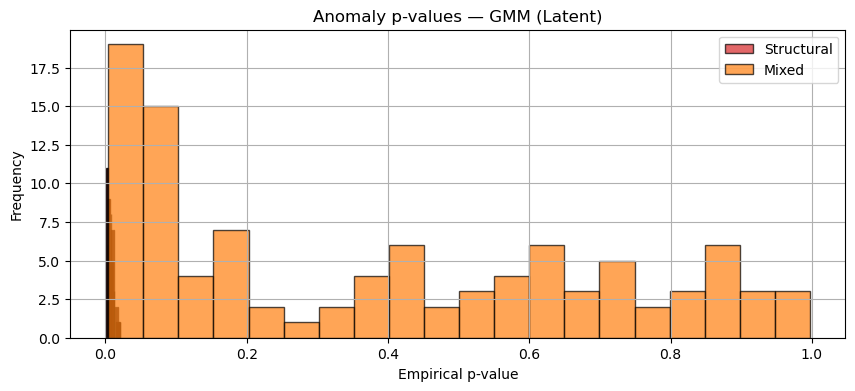

KS (Structural) → D = 0.979, p = 4.840e-168
KS (Mixed) → D = 0.253, p = 3.784e-06
Mean p-value (Structural): 0.006
Mean p-value (Mixed): 0.380


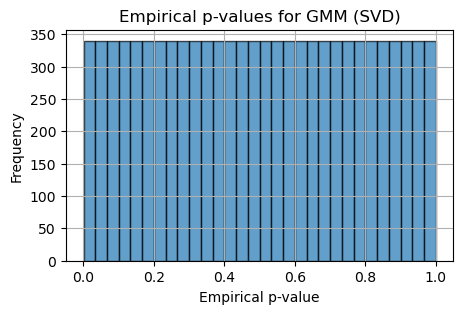

KS test vs. U[0,1] for GMM (SVD) → D = 0.000, p = 1.000e+00


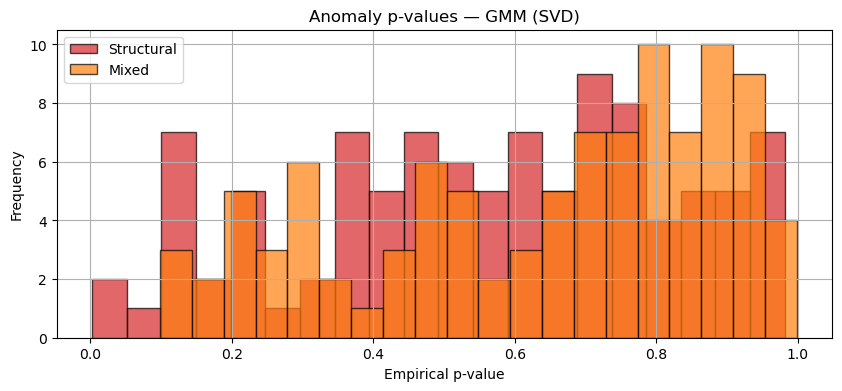

KS (Structural) → D = 0.158, p = 1.205e-02
KS (Mixed) → D = 0.241, p = 1.337e-05
Mean p-value (Structural): 0.561
Mean p-value (Mixed): 0.640


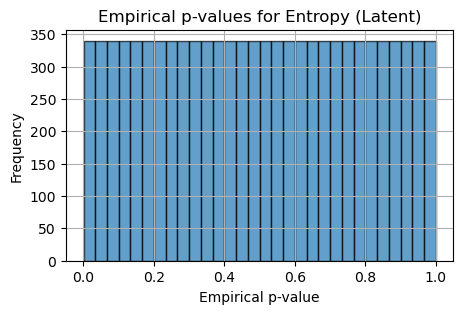

KS test vs. U[0,1] for Entropy (Latent) → D = 0.007, p = 6.702e-01


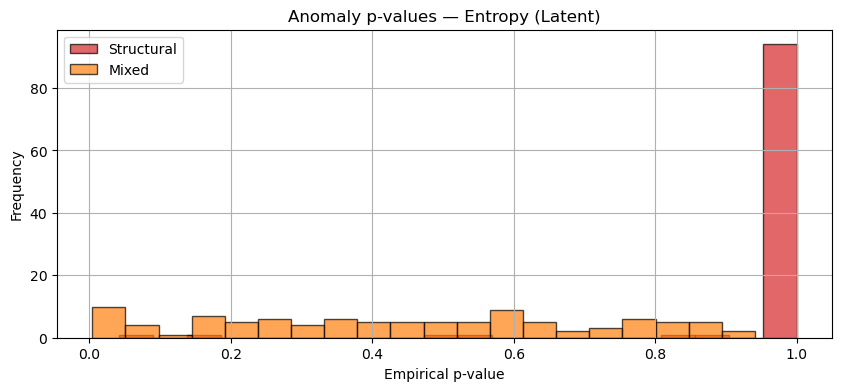

KS (Structural) → D = 0.894, p = 6.354e-98
KS (Mixed) → D = 0.117, p = 1.174e-01
Mean p-value (Structural): 0.967
Mean p-value (Mixed): 0.443


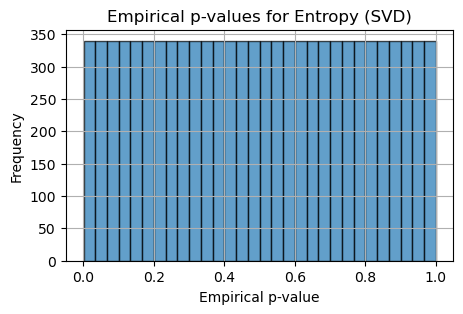

KS test vs. U[0,1] for Entropy (SVD) → D = 0.000, p = 1.000e+00


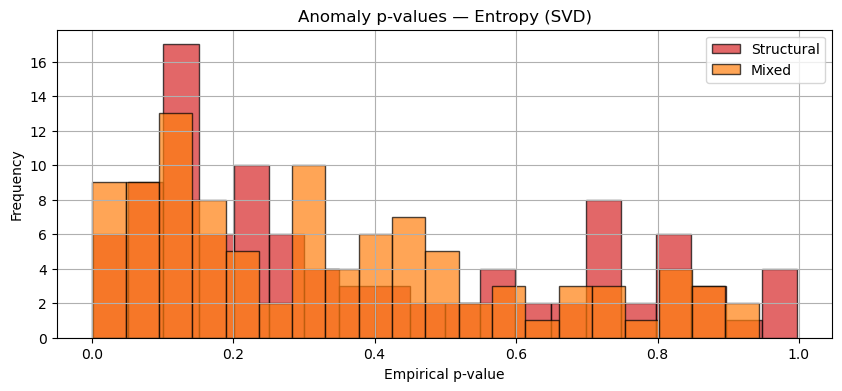

KS (Structural) → D = 0.251, p = 4.644e-06
KS (Mixed) → D = 0.282, p = 1.587e-07
Mean p-value (Structural): 0.383
Mean p-value (Mixed): 0.341


array([0.7622549 , 0.96372549, 0.97627451, ..., 0.88303922, 0.80735294,
       0.10970588])

In [13]:
def analyse_empirical_pvals(score_array, label_array=None, inverse=False, name='Score', show_anomalies=True):
    """
    Compute and plot empirical CDF p-values, perform KS test vs. U[0,1],
    and optionally analyse anomaly-specific p-values with consistent colour scheme.
    
    Colours:
        Normal       → Blue   (#1f77b4)
        Structural   → Red    (#d62728)
        Mixed        → Orange (#ff7f0e)
    """
    # Optional inversion if higher score = more anomalous
    scores = -score_array if inverse else score_array
    sorted_scores = np.sort(scores)
    pvals = np.searchsorted(sorted_scores, scores, side='right') / len(scores)
    
    # Overall histogram
    plt.figure(figsize=(5, 3))
    plt.hist(pvals, bins=30, edgecolor='k', alpha=0.7, color='#1f77b4')
    plt.title(f"Empirical p-values for {name}")
    plt.xlabel("Empirical p-value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # KS test overall
    ks_stat, ks_pval = ks_1samp(pvals, uniform.cdf)
    print(f"KS test vs. U[0,1] for {name} → D = {ks_stat:.3f}, p = {ks_pval:.3e}")

    if label_array is not None and show_anomalies:
        # Anomaly-specific p-values
        structural_p = pvals[label_array == 1]
        mixed_p = pvals[label_array == 2]

        # Plot anomaly histograms
        plt.figure(figsize=(10, 4))
        plt.hist(structural_p, bins=20, alpha=0.7, label='Structural',
                 edgecolor='black', color='#d62728')
        plt.hist(mixed_p, bins=20, alpha=0.7, label='Mixed',
                 edgecolor='black', color='#ff7f0e')
        plt.title(f"Anomaly p-values — {name}")
        plt.xlabel("Empirical p-value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.show()

        # KS test for anomalies
        ks_struct = ks_1samp(structural_p, uniform.cdf)
        ks_mixed = ks_1samp(mixed_p, uniform.cdf)

        print(f"KS (Structural) → D = {ks_struct.statistic:.3f}, p = {ks_struct.pvalue:.3e}")
        print(f"KS (Mixed) → D = {ks_mixed.statistic:.3f}, p = {ks_mixed.pvalue:.3e}")
        print(f"Mean p-value (Structural): {structural_p.mean():.3f}")
        print(f"Mean p-value (Mixed): {mixed_p.mean():.3f}")

    return pvals

# True labels: 0 = normal, 1 = structural, 2 = mixed
labels = true_labels

analyse_empirical_pvals(anomaly_score_df['kmeans_dist_latent'], anomaly_score_df['true_label'], inverse=False, name="KMeans (Latent)")
analyse_empirical_pvals(anomaly_score_df['kmeans_dist_svd'], anomaly_score_df['true_label'], inverse=False, name="KMeans (SVD)")
analyse_empirical_pvals(anomaly_score_df['gmm_score_latent'], anomaly_score_df['true_label'], inverse=True, name="GMM (Latent)")
analyse_empirical_pvals(anomaly_score_df['gmm_score_svd'], anomaly_score_df['true_label'], inverse=True, name="GMM (SVD)")
analyse_empirical_pvals(anomaly_score_df['entropy_latent'], anomaly_score_df['true_label'], inverse=True, name="Entropy (Latent)")
analyse_empirical_pvals(anomaly_score_df['entropy_svd'], anomaly_score_df['true_label'], inverse=True, name="Entropy (SVD)")

### MMSBM Hyperparameter Sensitivity (SVD-informed priors)

This block evaluates how **MMSBM** hyperparameters affect anomaly detection for LANL, using **SVD embedding only to initialise Dirichlet priors** (the model itself is fit to the adjacency subgraph).

---

#### `run_mmsbm_with_params(...)` — what it does

- **Inputs**
  - `X_subset`: SVD latent positions (used to build GMM soft memberships → Dirichlet prior).
  - `A_subset`: subgraph adjacency matrix (self-loops removed).
  - `labels_subset`: binary red-team labels (0 normal, 1 red).
  - `beta_alpha`, `beta_beta`: Beta prior for block matrix $B$.
  - `dirichlet_scale`: strength of the Dirichlet prior (scales GMM responsibilities).
  - `K`: number of latent communities.

- **Workflow**
  1. Fit **GMM(K)** on `X_subset`; scale responsibilities to form Dirichlet prior $a_i$.
  2. PyMC model:  
     $\pi_i \sim \mathrm{Dirichlet}(a_i)$, $B_{kl}\sim \mathrm{Beta}(\alpha,\beta)$,  
     $A_{ij}\sim \mathrm{Bernoulli}(p_{ij})$ with  
     $p_{ij}=\sum_{k,\ell}\pi_{ik}B_{k\ell}\pi_{j\ell}$ (diagonal masked out; probs clipped for stability).
  3. Fit with **ADVI**, then draw posterior samples of $\pi, B$.
  4. Compute node scores:
     - **Entropy**: $-\sum_k \pi_{ik}\log \pi_{ik}$ (normalised by $\log K$).
     - **Negative log-likelihood (NLL)**: vectorised sum over neighbours using posterior means.

- **Outputs**
  - `entropy_auc`, `nll_auc` (ROC-AUC vs red labels).
  - Per-node `entropy` and `negative_ll`.

---

#### Subset selection (as used in code)

- Sample **$n=1200$** nodes: up to **150 red** + remaining non-red.
- Build `X_svd_subset`, `A_svd_subset` (float, zero diagonal), and `labels_svd_subset`.
- Print subset composition and empirical edge density.

---

#### Sensitivity loop

- Sweep over $(\alpha,\beta,\text{scale})$ combinations:
  - **$\alpha,\beta$** control sparsity of $B$ (edge probabilities).
  - **`dirichlet_scale`** controls how strongly priors follow GMM soft memberships.
- For each combo, run the model and store **Entropy AUC** and **NLL AUC**.

---

#### Results & plots

- Print a **sorted table** of AUCs by hyperparameter combo.
- Report the **best** settings for each metric.
- Two **bar charts** (Entropy AUC, NLL AUC):
  - X-axis: label `α, β, D`.
  - Y-axis: AUC.
  - **Red bar** marks the top performer; values annotated above bars.
- Print a **metric correlation table** to see whether entropy and NLL rank settings similarly.

---

#### Parameter interpretation (quick guide)

- **Beta prior on $B$**:
  - $(0.5,0.5)$: near-uniform, high variance.
  - $(10,10)$: concentrated around 0.5 (denser mid-probability).
  - Larger **α** → denser; larger **β** → sparser.
- **Dirichlet scale**:
  - **Low**: weak prior (more flexible).
  - **High**: stronger pull towards spectral/GMM initialisation.

---

Subset composition:
  Normal: 600
  Structural: 100
  Mixed: 100
  Total: 800
  Subset density: 0.0095

Running hyperparameter sensitivity analysis...
Testing: beta_alpha=2.0, beta_beta=5.0, dirichlet_scale=10.0


Output()

Finished [100%]: Average Loss = 99,361


Testing: beta_alpha=0.5, beta_beta=0.5, dirichlet_scale=1.0


Output()

Finished [100%]: Average Loss = 1.841e+05


Testing: beta_alpha=10.0, beta_beta=10.0, dirichlet_scale=50.0


Output()

Finished [100%]: Average Loss = 1.8241e+05


Testing: beta_alpha=0.5, beta_beta=10.0, dirichlet_scale=10.0


Output()

Finished [100%]: Average Loss = 48,571


Testing: beta_alpha=10.0, beta_beta=0.5, dirichlet_scale=10.0


Output()

Finished [100%]: Average Loss = 1.1336e+06


Testing: beta_alpha=2.0, beta_beta=2.0, dirichlet_scale=5.0


Output()

Finished [100%]: Average Loss = 1.8292e+05


Testing: beta_alpha=5.0, beta_beta=1.0, dirichlet_scale=20.0


Output()

Finished [100%]: Average Loss = 5.4537e+05



=== HYPERPARAMETER SENSITIVITY RESULTS ===
 beta_alpha  beta_beta  dirichlet_scale  entropy_struct_auc  entropy_mixed_auc  nll_struct_auc  nll_mixed_auc
        2.0        5.0             10.0               0.117              0.706           0.440          0.441
        0.5        0.5              1.0               0.141              0.692           0.212          0.527
       10.0       10.0             50.0               0.109              0.712           0.437          0.271
        0.5       10.0             10.0               0.116              0.726           0.474          0.414
       10.0        0.5             10.0               0.103              0.706           0.471          0.538
        2.0        2.0              5.0               0.124              0.702           0.275          0.511
        5.0        1.0             20.0               0.110              0.709           0.401          0.642

=== BEST PARAMETERS FOR EACH METRIC ===
entropy_struct_auc: 0.141
  beta_al

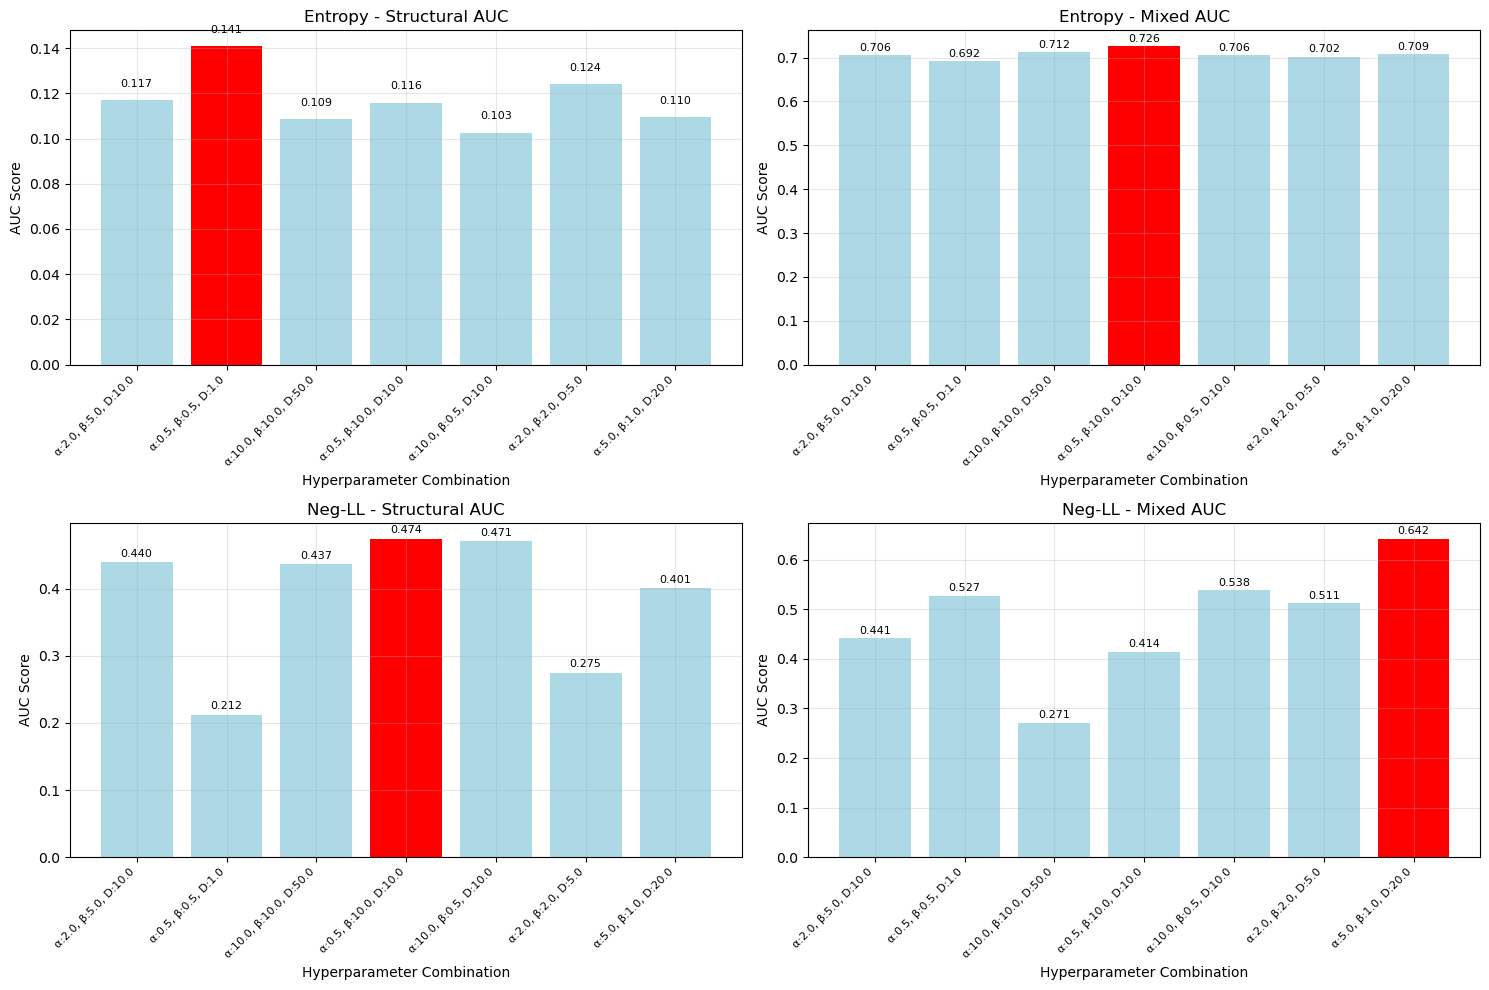


=== PARAMETER IMPACT ANALYSIS ===
Beta Parameters (Edge Density Prior):
- beta_alpha, beta_beta = (0.5, 0.5): Uniform prior, high variance
- beta_alpha, beta_beta = (2.0, 5.0): Favours sparse networks
- beta_alpha, beta_beta = (10.0, 10.0): Concentrated around 0.5
- Higher beta_alpha: Favours denser networks
- Higher beta_beta: Favours sparser networks

Dirichlet Scale (Community Assignment Prior):
- Low scale (1.0): Weak prior, more uncertainty
- High scale (50.0): Strong prior, follows spectral initialisation closely
- Affects how much the model deviates from GMM initialisation

=== METRIC CORRELATIONS ===
                    entropy_struct_auc  entropy_mixed_auc  nll_struct_auc  \
entropy_struct_auc               1.000             -0.594          -0.872   
entropy_mixed_auc               -0.594              1.000           0.793   
nll_struct_auc                  -0.872              0.793           1.000   
nll_mixed_auc                    0.126             -0.406          -0.316  

In [14]:
# Complete MMSBM Hyperparameter Sensitivity Analysis - Latent Space

def run_mmsbm_with_params(X_subset, A_subset, labels_subset, 
                         beta_alpha, beta_beta, dirichlet_scale, K=k):
    """
    Run MMSBM with specific hyperparameters and return AUC scores
    """
    n_subset = len(X_subset)
    
    # Spectral-informed prior
    gmm = GaussianMixture(n_components=K, random_state=42).fit(X_subset)
    soft_memberships = gmm.predict_proba(X_subset)
    a_init = np.clip(soft_memberships * dirichlet_scale, 1e-3, None)  # scaled Dirichlet prior
    
    # Bayesian MMSBM
    with pm.Model() as model:
        pi = pm.Dirichlet('pi', a=a_init, shape=(n_subset, K))
        B = pm.Beta('B', alpha=beta_alpha, beta=beta_beta, shape=(K, K))
        
        pi_i = pi.dimshuffle(0, 'x', 1)
        pi_j = pi.dimshuffle('x', 0, 1)
        
        edge_probs = pt.sum(
            pt.sum(pi_i.dimshuffle(0, 1, 2, 'x') * B.dimshuffle('x', 'x', 0, 1) * 
                   pi_j.dimshuffle(1, 0, 'x', 2), axis=3), axis=2
        )
        edge_probs = edge_probs * (1 - pt.eye(n_subset))
        edge_probs = pt.clip(edge_probs, 1e-6, 1 - 1e-6)
        
        pm.Bernoulli('obs', p=edge_probs, observed=A_subset)
        
        # Inference
        approx = pm.fit(5000, method='advi', random_seed=42)  # Reduced for speed
        trace = approx.sample(200, random_seed=42)
    
    # Extract measures
    pi_mean = trace.posterior['pi'].mean(dim=["chain", "draw"]).values
    B_mean = trace.posterior['B'].mean(dim=["chain", "draw"]).values
    
    # Entropy
    entropy = -np.sum(pi_mean * np.log(pi_mean + 1e-10), axis=1) / np.log(K)
    
    # Negative log-likelihood (simplified for speed)
    def compute_node_nll(node_idx):
        pi_i = pi_mean[node_idx]
        nll = 0.0
        for j in range(n_subset):
            if node_idx == j:
                continue
            pi_j = pi_mean[j]
            edge_prob = np.sum(pi_i[:, None] * B_mean * pi_j[None, :])
            edge_prob = np.clip(edge_prob, 1e-6, 1 - 1e-6)
            
            if A_subset[node_idx, j] == 1:
                nll += -np.log(edge_prob)
            else:
                nll += -np.log(1 - edge_prob)
        return nll
    
    negative_ll = np.array([compute_node_nll(i) for i in range(n_subset)])

    assert not np.any(np.isnan(entropy)), "NaN detected in entropy"
    assert not np.any(np.isnan(negative_ll)), "NaN detected in negative log-likelihood"
    
    # AUC calculations
    y_true_struct = (labels_subset == 1).astype(int)
    y_true_mixed = (labels_subset == 2).astype(int)
    
    results = {
        'entropy_struct_auc': roc_auc_score(y_true_struct, entropy),
        'entropy_mixed_auc': roc_auc_score(y_true_mixed, entropy),
        'nll_struct_auc': roc_auc_score(y_true_struct, negative_ll),
        'nll_mixed_auc': roc_auc_score(y_true_mixed, negative_ll),
        'entropy': entropy,
        'negative_ll': negative_ll
    }
    
    return results

# === SUBSET CREATION ===
# Parameters
K = 5  
subset_size = 800
structural_count = 100
mixed_count = 100

# Assume true_labels: 0=normal, 1=structural anomaly, 2=mixed anomaly
normal_idx = np.where(true_labels == 0)[0]
structural_idx = np.where(true_labels == 1)[0]
mixed_idx = np.where(true_labels == 2)[0]

# Add shuffle for randomness
np.random.shuffle(normal_idx)

# Subsample
subset_structural = structural_idx[:min(structural_count, len(structural_idx))]
subset_mixed = mixed_idx[:min(mixed_count, len(mixed_idx))]
subset_normal = normal_idx[:(subset_size - len(subset_structural) - len(subset_mixed))]
subset_idx = np.concatenate([subset_structural, subset_mixed, subset_normal])
n_subset = len(subset_idx)

X_subset = X_scaled[subset_idx]  # or X_scaled/X_svd_aligned_full
labels_subset = true_labels[subset_idx]
A_subset = A[np.ix_(subset_idx, subset_idx)].astype(float)
np.fill_diagonal(A_subset, 0)

# Validation check
print(f"Subset composition:")
print(f"  Normal: {len(subset_normal)}")
print(f"  Structural: {len(subset_structural)}")
print(f"  Mixed: {len(subset_mixed)}")
print(f"  Total: {n_subset}")
print(f"  Subset density: {A_subset.sum() / (n_subset * (n_subset - 1)):.4f}")

# === SENSITIVITY ANALYSIS ===
# Define hyperparameter ranges to test
beta_alpha_values = [0.5, 1.0, 2.0, 5.0, 10.0]
beta_beta_values = [0.5, 1.0, 2.0, 5.0, 10.0]
dirichlet_scale_values = [1.0, 5.0, 10.0, 20.0, 50.0]

# Run sensitivity analysis
print("\nRunning hyperparameter sensitivity analysis...")
results_df = []

# Test different combinations (subset for computational efficiency)
param_combinations = [
    (2.0, 5.0, 10.0),   # Original
    (0.5, 0.5, 1.0),    # Low concentration
    (10.0, 10.0, 50.0), # High concentration
    (0.5, 10.0, 10.0),  # Sparse edges
    (10.0, 0.5, 10.0),  # Dense edges
    (2.0, 2.0, 5.0),    # Balanced
    (5.0, 1.0, 20.0),   # Mixed
]

for beta_alpha, beta_beta, dirichlet_scale in param_combinations:
    print(f"Testing: beta_alpha={beta_alpha}, beta_beta={beta_beta}, dirichlet_scale={dirichlet_scale}")
    
    try:
        results = run_mmsbm_with_params(X_subset, A_subset, labels_subset, 
                                      beta_alpha, beta_beta, dirichlet_scale, K=K)
        
        results_df.append({
            'beta_alpha': beta_alpha,
            'beta_beta': beta_beta,
            'dirichlet_scale': dirichlet_scale,
            'entropy_struct_auc': results['entropy_struct_auc'],
            'entropy_mixed_auc': results['entropy_mixed_auc'],
            'nll_struct_auc': results['nll_struct_auc'],
            'nll_mixed_auc': results['nll_mixed_auc']
        })
        
    except Exception as e:
        print(f"  Failed: {e}")
        continue

results_df = pd.DataFrame(results_df)

# Display results
print("\n=== HYPERPARAMETER SENSITIVITY RESULTS ===")
print(results_df.round(3).to_string(index=False))

# Find best parameters for each metric
print("\n=== BEST PARAMETERS FOR EACH METRIC ===")
for metric in ['entropy_struct_auc', 'entropy_mixed_auc', 'nll_struct_auc', 'nll_mixed_auc']:
    best_idx = results_df[metric].idxmax()
    best_row = results_df.iloc[best_idx]
    print(f"{metric}: {best_row[metric]:.3f}")
    print(f"  beta_alpha={best_row['beta_alpha']}, beta_beta={best_row['beta_beta']}, dirichlet_scale={best_row['dirichlet_scale']}")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

metrics = ['entropy_struct_auc', 'entropy_mixed_auc', 'nll_struct_auc', 'nll_mixed_auc']
titles = ['Entropy - Structural AUC', 'Entropy - Mixed AUC', 'Neg-LL - Structural AUC', 'Neg-LL - Mixed AUC']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    
    # Create a combined parameter label for x-axis
    param_labels = [f"α:{row['beta_alpha']}, β:{row['beta_beta']}, D:{row['dirichlet_scale']}" 
                   for _, row in results_df.iterrows()]
    
    bars = ax.bar(range(len(results_df)), results_df[metric], 
                  color=['red' if x == results_df[metric].max() else 'lightblue' for x in results_df[metric]])
    
    ax.set_title(title)
    ax.set_ylabel('AUC Score')
    ax.set_xlabel('Hyperparameter Combination')
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(param_labels, rotation=45, ha='right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Parameter impact analysis
print("\n=== PARAMETER IMPACT ANALYSIS ===")

# Effect of beta parameters on edge density prior
print("Beta Parameters (Edge Density Prior):")
print("- beta_alpha, beta_beta = (0.5, 0.5): Uniform prior, high variance")
print("- beta_alpha, beta_beta = (2.0, 5.0): Favours sparse networks")
print("- beta_alpha, beta_beta = (10.0, 10.0): Concentrated around 0.5")
print("- Higher beta_alpha: Favours denser networks")
print("- Higher beta_beta: Favours sparser networks")

print("\nDirichlet Scale (Community Assignment Prior):")
print("- Low scale (1.0): Weak prior, more uncertainty")
print("- High scale (50.0): Strong prior, follows spectral initialisation closely")
print("- Affects how much the model deviates from GMM initialisation")

# Correlation analysis
print("\n=== METRIC CORRELATIONS ===")
correlation_matrix = results_df[metrics].corr()
print(correlation_matrix.round(3))

Subset (SVD) composition:
  Normal: 600
  Structural: 100
  Mixed: 100
  Total: 800
  Subset density: 0.0091

Running hyperparameter sensitivity analysis on X_svd_aligned_full...
Testing: beta_alpha=2.0, beta_beta=5.0, dirichlet_scale=10.0


Output()

Finished [100%]: Average Loss = 94,084


Testing: beta_alpha=0.5, beta_beta=0.5, dirichlet_scale=1.0


Output()

Finished [100%]: Average Loss = 1.7881e+05


Testing: beta_alpha=10.0, beta_beta=10.0, dirichlet_scale=50.0


Output()

Finished [100%]: Average Loss = 1.7619e+05


Testing: beta_alpha=0.5, beta_beta=10.0, dirichlet_scale=10.0


Output()

Finished [100%]: Average Loss = 43,647


Testing: beta_alpha=10.0, beta_beta=0.5, dirichlet_scale=10.0


Output()

Finished [100%]: Average Loss = 1.1151e+06


Testing: beta_alpha=2.0, beta_beta=2.0, dirichlet_scale=5.0


Output()

Finished [100%]: Average Loss = 1.7678e+05


Testing: beta_alpha=5.0, beta_beta=1.0, dirichlet_scale=20.0


Output()

Finished [100%]: Average Loss = 5.3524e+05



=== SVD HYPERPARAMETER SENSITIVITY RESULTS ===
 beta_alpha  beta_beta  dirichlet_scale  entropy_struct_auc  entropy_mixed_auc  nll_struct_auc  nll_mixed_auc
        2.0        5.0             10.0               0.440              0.489           0.463          0.388
        0.5        0.5              1.0               0.438              0.481           0.449          0.377
       10.0       10.0             50.0               0.442              0.492           0.454          0.389
        0.5       10.0             10.0               0.449              0.497           0.472          0.395
       10.0        0.5             10.0               0.432              0.476           0.449          0.388
        2.0        2.0              5.0               0.437              0.484           0.448          0.378
        5.0        1.0             20.0               0.435              0.481           0.417          0.359

=== BEST PARAMETERS FOR EACH METRIC (SVD) ===
entropy_struct_auc: 0.449

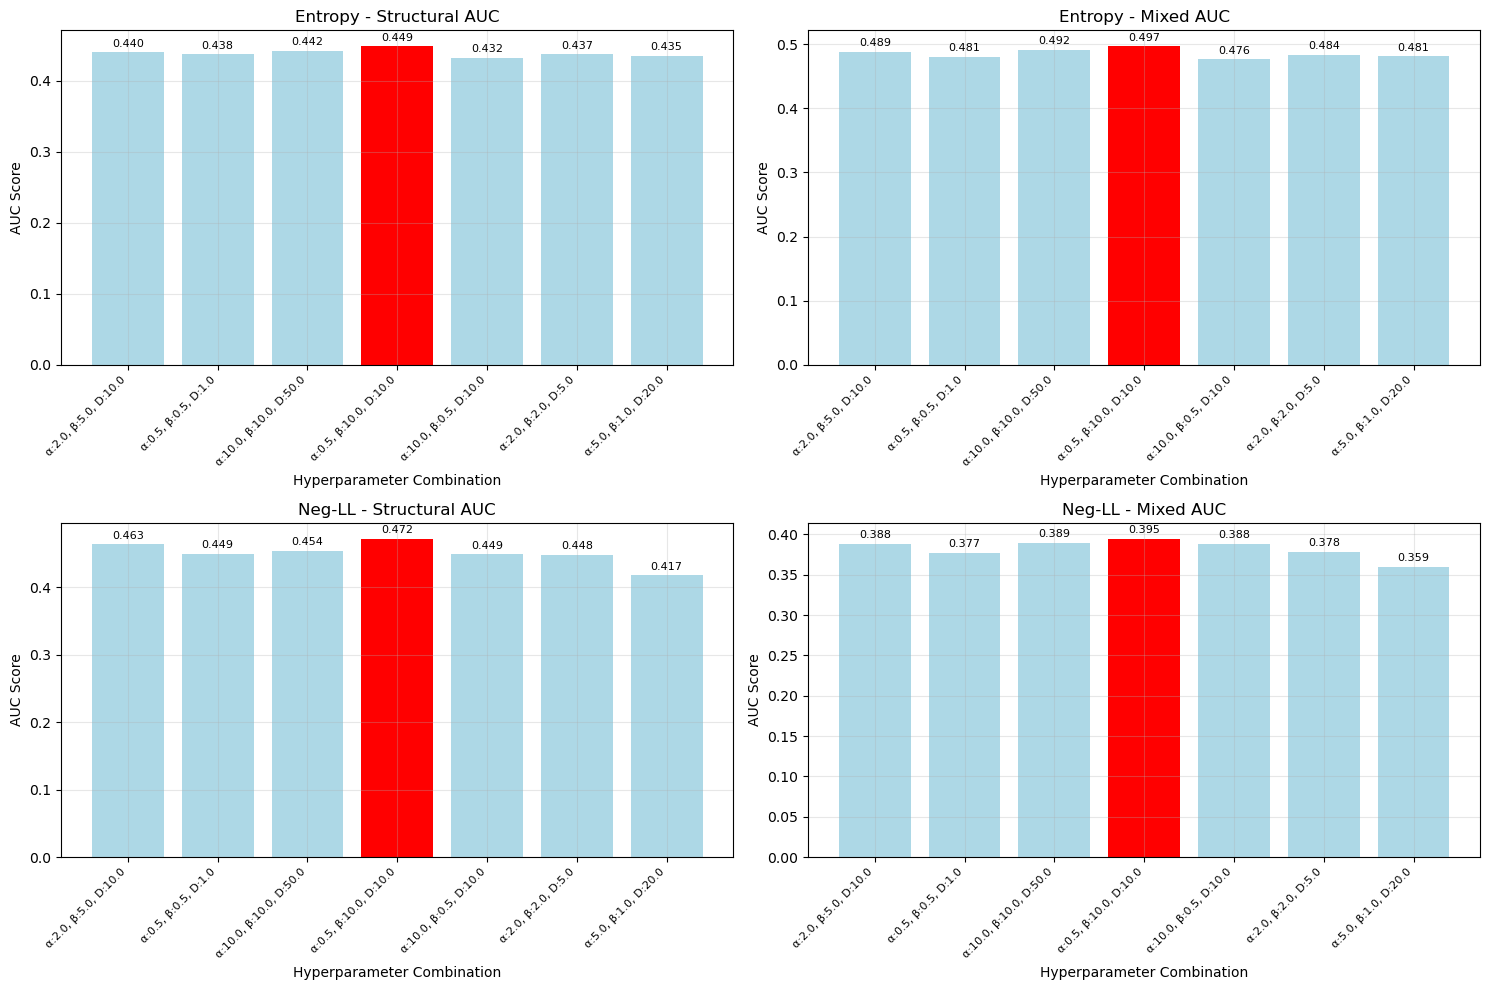

In [15]:
# === SUBSET CREATION for X_svd_aligned_full ===
K = 5  
subset_size = 800
structural_count = 100
mixed_count = 100

# Indices
normal_idx = np.where(true_labels == 0)[0]
structural_idx = np.where(true_labels == 1)[0]
mixed_idx = np.where(true_labels == 2)[0]
np.random.shuffle(normal_idx)

subset_structural = structural_idx[:min(structural_count, len(structural_idx))]
subset_mixed = mixed_idx[:min(mixed_count, len(mixed_idx))]
subset_normal = normal_idx[:(subset_size - len(subset_structural) - len(subset_mixed))]
subset_svd_idx = np.concatenate([subset_structural, subset_mixed, subset_normal])
n_svd_subset = len(subset_svd_idx)

X_svd_subset = X_svd_aligned_full[subset_svd_idx]
labels_svd_subset = true_labels[subset_svd_idx]
A_svd_subset = A[np.ix_(subset_svd_idx, subset_svd_idx)].astype(float)
np.fill_diagonal(A_svd_subset, 0)

print(f"Subset (SVD) composition:")
print(f"  Normal: {len(subset_normal)}")
print(f"  Structural: {len(subset_structural)}")
print(f"  Mixed: {len(subset_mixed)}")
print(f"  Total: {n_svd_subset}")
print(f"  Subset density: {A_svd_subset.sum() / (n_svd_subset * (n_svd_subset - 1)):.4f}")

# === HYPERPARAMETER SENSITIVITY ANALYSIS for SVD Subset ===
print("\nRunning hyperparameter sensitivity analysis on X_svd_aligned_full...")
results_svd_df = []

param_combinations = [
    (2.0, 5.0, 10.0),
    (0.5, 0.5, 1.0),
    (10.0, 10.0, 50.0),
    (0.5, 10.0, 10.0),
    (10.0, 0.5, 10.0),
    (2.0, 2.0, 5.0),
    (5.0, 1.0, 20.0),
]

for beta_alpha, beta_beta, dirichlet_scale in param_combinations:
    print(f"Testing: beta_alpha={beta_alpha}, beta_beta={beta_beta}, dirichlet_scale={dirichlet_scale}")
    
    try:
        results = run_mmsbm_with_params(
            X_svd_subset, A_svd_subset, labels_svd_subset, 
            beta_alpha, beta_beta, dirichlet_scale, K=K
        )
        
        results_svd_df.append({
            'beta_alpha': beta_alpha,
            'beta_beta': beta_beta,
            'dirichlet_scale': dirichlet_scale,
            'entropy_struct_auc': results['entropy_struct_auc'],
            'entropy_mixed_auc': results['entropy_mixed_auc'],
            'nll_struct_auc': results['nll_struct_auc'],
            'nll_mixed_auc': results['nll_mixed_auc']
        })
        
    except Exception as e:
        print(f"  Failed: {e}")
        continue

results_svd_df = pd.DataFrame(results_svd_df)


# === RESULTS DISPLAY ===
print("\n=== SVD HYPERPARAMETER SENSITIVITY RESULTS ===")
print(results_svd_df.round(3).to_string(index=False))

print("\n=== BEST PARAMETERS FOR EACH METRIC (SVD) ===")
for metric in ['entropy_struct_auc', 'entropy_mixed_auc', 'nll_struct_auc', 'nll_mixed_auc']:
    best_idx = results_svd_df[metric].idxmax()
    best_row = results_svd_df.iloc[best_idx]
    print(f"{metric}: {best_row[metric]:.3f}")
    print(f"  beta_alpha={best_row['beta_alpha']}, beta_beta={best_row['beta_beta']}, dirichlet_scale={best_row['dirichlet_scale']}")


# === VISUALISATION for SVD Results ===
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

metrics = ['entropy_struct_auc', 'entropy_mixed_auc', 'nll_struct_auc', 'nll_mixed_auc']
titles = ['Entropy - Structural AUC', 'Entropy - Mixed AUC', 'Neg-LL - Structural AUC', 'Neg-LL - Mixed AUC']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    
    param_labels = [f"α:{row['beta_alpha']}, β:{row['beta_beta']}, D:{row['dirichlet_scale']}" 
                    for _, row in results_svd_df.iterrows()]
    
    bars = ax.bar(range(len(results_svd_df)), results_svd_df[metric], 
                  color=['red' if x == results_svd_df[metric].max() else 'lightblue' 
                         for x in results_svd_df[metric]])
    
    ax.set_title(title)
    ax.set_ylabel('AUC Score')
    ax.set_xlabel('Hyperparameter Combination')
    ax.set_xticks(range(len(results_svd_df)))
    ax.set_xticklabels(param_labels, rotation=45, ha='right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()